In [1]:
%load_ext autoreload
%autoreload 2
from imports.networks import *
from imports.data import *
from imports.params import p
import matplotlib.pyplot as plt

In [2]:
### set matplotlib parameters
SMALL_SIZE = 8
MEDIUM_SIZE = 8
BIGGER_SIZE = 10

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=5)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc('lines', linewidth=0.7)
### note: setting usetex=True makes all plots take at least 20-30 seconds to generate
plt.rc('text', usetex=False)
plt.rc('font', family='Nimbus Roman')

# plt.rc('font', family='Times New Roman')

# Test: new plots for paper

In [3]:
with open("/home/tol/Documents/Thesis/data/" + "predictions.json", 'r') as filepath:
    predictions = json.load(filepath)

def get_mass_slice(p):
    indices = np.load(p["data_path"] + p_to_filename(p, data=True) + "_halo_indices.npy")
    indices = indices[:int(len(indices)*p["test_size"])]
    masses = np.load(p["data_path"] + p_to_filename(p, data=True) + "_masses.npy")
    masses = masses[:int(len(masses)*p["test_size"])]
    mask = np.logical_and(masses > 10**13.4, masses < 10**13.6)
    return mask, np.log10(masses[mask])
# print([np.array(l) for l in predictions["linear_predictions"+p_to_filename(p)]])

def MAE(pred, true):
    return np.mean(np.abs(pred - true))

def error(pred, true):
    return np.mean(pred - true)

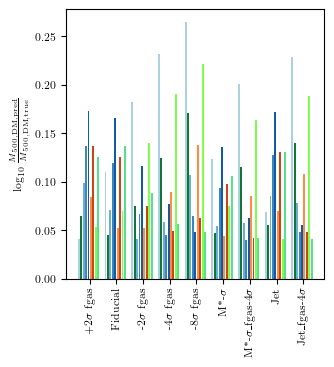

In [53]:
fig, ax = plt.subplots(figsize=(10/3, 3.5))

p["noisy"] = False
p["simtype"] = "single"
p["model"] = "HYDRO_FIDUCIAL"
for j, model in enumerate(simulation_variations):
    p["model"] = model
    for i, model in enumerate(simulation_variations):
        p_test = p.copy()
        p_test["model"] = model
        slice_indices, true_masses = get_mass_slice(p_test)
        predicted_masses = np.array(predictions["linear_predictions"+p_to_filename(p)][i])[slice_indices]
        ax.bar(i+11*j, MAE(predicted_masses, true_masses), color=colors[i])
plt.ylabel(r"$\log_{10} \frac{M_{500, \mathrm{DM}, \mathrm{pred}}}{M_{500, \mathrm{DM}, \mathrm{true}}}$")
plt.xticks(np.linspace(9.0/2.0, 9.0/2.0 + 8*11, len(simulation_variations)), names, rotation=90)
plt.savefig("/home/tol/Documents/Thesis/plots/" + "barplot_test", dpi=200, bbox_inches="tight")
plt.show()

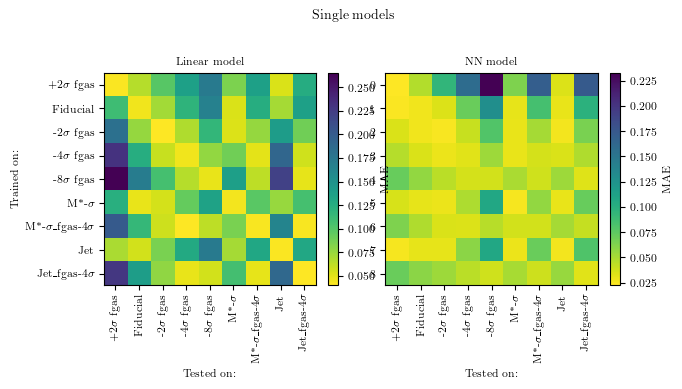

In [101]:
fig = plt.figure(figsize=(10/3*2, 3.5))
axs = fig.subplots(1, 2)
matrix_linear = np.zeros((9, 9))
matrix_nn = np.zeros((9, 9))
p["noisy"] = False
p["simtype"] = "single"
for j, model in enumerate(simulation_variations):
    p["model"] = model
    for i, model in enumerate(simulation_variations):
        p_test = p.copy()
        p_test["model"] = model
        slice_indices, true_masses = get_mass_slice(p_test)
        linear_predicted_masses = np.array(predictions["linear_predictions"+p_to_filename(p)][i])[slice_indices]
        nn_predicted_masses = np.array(predictions["nn_predictions"+p_to_filename(p)][i])[slice_indices]
        matrix_linear[j, i] = MAE(linear_predicted_masses, true_masses)
        matrix_nn[j, i] = MAE(nn_predicted_masses, true_masses)
map1 = axs[0].imshow(matrix_linear, cmap="viridis_r")
map2 = axs[1].imshow(matrix_nn, cmap="viridis_r")
fig.colorbar(map1, ax=axs[0], label="MAE", fraction=0.045)
fig.colorbar(map2, ax=axs[1], label="MAE", fraction=0.045)
axs[0].set_xticks(range(9), names, rotation=90)
axs[1].set_xticks(range(9), names, rotation=90)
axs[0].set_yticks(range(9), names)
axs[0].set_ylabel("Trained on:")
axs[0].set_xlabel("Tested on:")
axs[1].set_xlabel("Tested on:")
plt.title("Single models")
axs[0].set_title("Linear model")
axs[1].set_title("NN model")
fig.suptitle("Single models")
plt.savefig("/home/tol/Documents/Thesis/plots/" + "Image comparison", dpi=200, bbox_inches="tight")
plt.show()

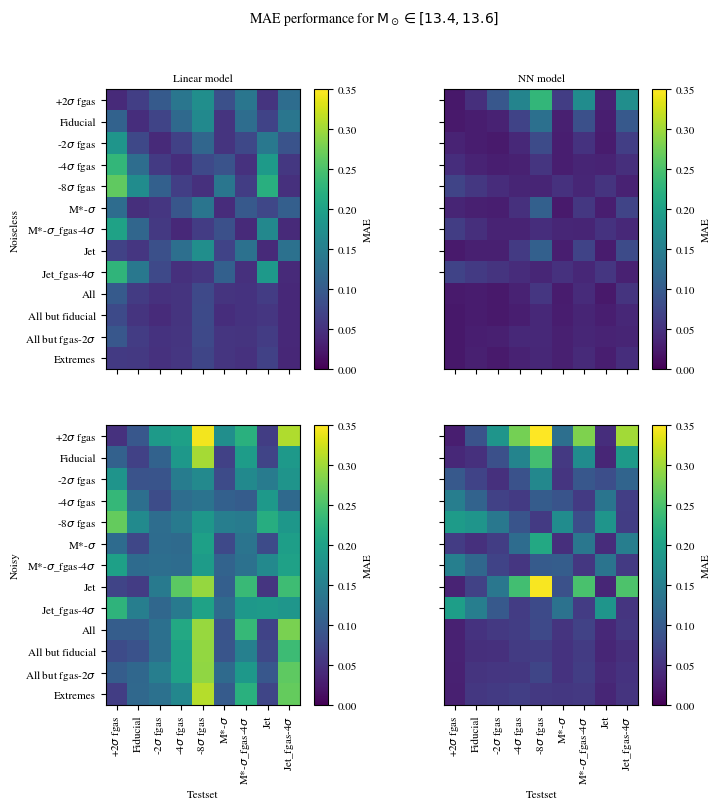

In [9]:
def get_row(p, lin_nn):
    row = []
    for i, model in enumerate(simulation_variations):
        p_test = p.copy()
        p_test["model"] = model
        slice_indices, true_masses = get_mass_slice(p_test)
        predicted_masses = np.array(predictions[lin_nn+p_to_filename(p)][i])[slice_indices]
        row.append(MAE(predicted_masses, true_masses))
    return row

fig = plt.figure(figsize=(8, 8))
axs = fig.subplots(2, 2)
for n_i, noisy in enumerate([False, True]):
    for lin_nn_i, lin_nn in enumerate(["linear_predictions", "nn_predictions"]):
        p["noisy"] = noisy
        matrix = np.zeros((13, 9))

        p["simtype"] = "single"
        for i in range(9):
            p["model"] = simulation_variations[i]
            matrix[i] = get_row(p, lin_nn)

        p["simtype"] = "all"
        p["model"] = "HYDRO_FIDUCIAL"
        matrix[9] = get_row(p, lin_nn)

        p["simtype"] = "all_but"
        p["model"] = "HYDRO_FIDUCIAL"
        matrix[10] = get_row(p, lin_nn)

        p["simtype"] = "all_but"
        p["model"] = "HYDRO_STRONG_AGN"
        matrix[11] = get_row(p, lin_nn)

        p["simtype"] = "extremes"
        p["model"] = "HYDRO_FIDUCIAL"
        matrix[12] = get_row(p, lin_nn)

        cmap = axs[n_i, lin_nn_i].imshow(matrix, vmin=0, vmax=0.35)
        fig.colorbar(cmap, ax=axs[n_i, lin_nn_i], label="MAE")
axs[0, 0].set_xticks(range(9), [""]*9)
axs[0, 1].set_xticks(range(9), [""]*9)
axs[1, 0].set_xticks(range(9), names, rotation=90)
axs[1, 1].set_xticks(range(9), names, rotation=90)
axs[0, 0].set_yticks(range(13), np.append(names, ["All", "All but fiducial", r"All but fgas-2$\sigma$", "Extremes"]))
axs[1, 0].set_yticks(range(13), np.append(names, ["All", "All but fiducial", r"All but fgas-2$\sigma$", "Extremes"]))
axs[0, 1].set_yticks(range(9), [""]*9)
axs[1, 1].set_yticks(range(9), [""]*9)
axs[0, 0].set_title("Linear model")
axs[0, 1].set_title("NN model")
axs[0, 0].set_ylabel("Noiseless")
axs[1, 0].set_ylabel("Noisy")
axs[1, 0].set_xlabel("Testset")
axs[1, 1].set_xlabel("Testset")
fig.suptitle(r"MAE performance for $\mathrm{M_\odot} \in [13.4, 13.6]$")
plt.savefig("/home/tol/Documents/Thesis/plots/" + "imshow plot test", dpi=300, bbox_inches="tight")
plt.show()


# Test: result plots

In [15]:
### initialize parameters and set which NN model is used
from scipy.stats import bootstrap
trainmodel = "HYDRO_FIDUCIAL"
testmodels = ["HYDRO_WEAK_AGN", "HYDRO_FIDUCIAL", "HYDRO_STRONG_AGN", "HYDRO_STRONGER_AGN", "HYDRO_STRONGEST_AGN", "HYDRO_STRONG_SUPERNOVA", "HYDRO_STRONGER_AGN_STRONG_SUPERNOVA", "HYDRO_JETS_published", "HYDRO_STRONG_JETS_published"]
colors = ['#abd0e6', '#117733','#6aaed6','#3787c0','#105ba4', '#FF8C40','#CC4314','#7EFF4B','#55E18E']
names = [r"+2$\sigma$ fgas", "Fiducial", r"-2$\sigma$ fgas", r"-4$\sigma$ fgas", r"-8$\sigma$ fgas", r"M*-$\sigma$", r"M*-$\sigma$_fgas-4$\sigma$", r"Jet", r"Jet_fgas-4$\sigma$"]

# p["redshift"] = 0.5
p["noisy"] = False
p["model"] = trainmodel
p["simtype"] = "single"
data = Data(p)

name_addon = ""
if p["simtype"] != "single":
    name_addon += "_"+p["simtype"]
if p["noisy"]:
    name_addon += "_noisy"

filename = p_to_filename(p)+name_addon
nnmodel = torch.load(f"{p['model_path']}/{filename}.pt", map_location=torch.device("cpu"))

def rmse(d):
    return np.sqrt(np.mean((d)**2))
def error(a):
    return np.median(a)

In [12]:
### Linear prediction

def powerlaw2d(xy, L0_low, p1_low, p2_low, L0_high, p1_high, p2_high, M0):
    x, y = xy
    fit_low = np.zeros(len(x))
    fit_low[x < L0_low] = p1_low * (x[x < L0_low] - L0_low)
    fit_low[x >= L0_low] = p2_low * (x[x >= L0_low] - L0_low)
    fit_high = np.zeros(len(y))
    fit_high[y < L0_high] = p1_high * (y[y < L0_high] - L0_high)
    fit_high[y >= L0_high] = p2_high * (y[y >= L0_high] - L0_high)
    return fit_low + fit_high + M0

def predict_with_scaling_relations(testmodels, verbose=False):
    ### load scaling relation for trainmodel
    p["model"] = trainmodel
    bgd = json.load(open(p["model_path"]+"bgd.json", "r"))
    bgd_low = bgd["bgd_low"] * bgd["z0"+str(p["redshift"])[2:]]["fov"]**2 * p["obs_time"] /64/64 * p["modules"] #counts / pixel
    bgd_high = bgd["bgd_high"] * bgd["z0"+str(p["redshift"])[2:]]["fov"]**2 * p["obs_time"] /64/64 * p["modules"]
    predictions = []
    for testmodel in testmodels:
        ### load images in testset
        p["model"] = testmodel
        if p["noisy"]:
            ### workaround since old convolution was wrong, so recalculate noise here
            p["noisy"] = False
            data = Data(p)
            data.load_testset(filename=p_to_filename(p))
            data.images = data.add_noise(data.images)
            p["noisy"] = True
        else:
            data = Data(p)
            data.load_testset(filename=p_to_filename(p))

        ### add pixel values within r_500
        pixel_size = 4 * 1000 / 64  #4Mpc * 1000kpc/Mpc / 64pixels
        points_low = []
        points_high = []
        for i, haloindex in enumerate(data.indices):
            r = data.soap_file[f"{data.selection_type}/SORadius"][haloindex] * 1000 #kpc
            radius = r / pixel_size
            X, Y = np.ogrid[:p['resolution'], :p['resolution']]
            dist_from_center = np.sqrt((X + 0.5-int(p['resolution']/2))**2+(Y+0.5-int(p['resolution']/2))**2)
            mask_circ = dist_from_center<=radius
            if p["noisy"]:
                ### do not allow negative values for photon counts
                luminosity_circle_low = np.log10(max(np.sum(data.images[i, 0][mask_circ] - bgd_low), 1))
                luminosity_circle_high = np.log10(max(np.sum(data.images[i, 1][mask_circ] - bgd_high), 1))
            else:
                luminosity_circle_low = np.log10(np.sum(data.images[i, 0][mask_circ]))
                luminosity_circle_high = np.log10(np.sum(data.images[i, 1][mask_circ]))

            points_low.append(luminosity_circle_low)
            points_high.append(luminosity_circle_high)
        
        ### make prediction using parameters found by scaling_relation.py
        if p["simtype"] == "single" or p["simtype"] == "all_but":
            coeffs = json.load(open(p["model_path"]+"powerlawcoeffs.json", "r"))[p["simtype"]][trainmodel]
        else:
            coeffs = json.load(open(p["model_path"]+"powerlawcoeffs.json", "r"))[p["simtype"]]
        xy = np.append(np.array(points_low)[np.newaxis, :], np.array(points_high)[np.newaxis, :], axis=0)
        predictions.append(powerlaw2d(xy, coeffs[0], coeffs[1], coeffs[2], coeffs[3], coeffs[4], coeffs[5], coeffs[6]))
        if verbose: print(f"{testmodel} done")
    return predictions
    

In [13]:
### neural network prediction

def predict_with_nn(testmodels, verbose=False):
    p["model"] = trainmodel
    ### load normalization factors which were used during model training
    _, _, _, _, _, _, mean_x, mean_y, std_x, std_y = load_nn_dataset(p)
    predictions = []
    
    p_all = p.copy()
    p_all["simtype"] = "all"
    ### load data normalized by all images (so incorrect normalization)
    testx, _, _, _, _, _, wrong_mean_x, _, wrong_std_x, _ = load_nn_dataset(p_all)
    for i in range(len(testx)):
        with torch.no_grad():
            #scale back to normal physical values and normalize with mean and std used during training
            testset = (testx[i] * wrong_std_x[np.newaxis, :, np.newaxis, np.newaxis] + wrong_mean_x[np.newaxis, :, np.newaxis, np.newaxis] - mean_x[np.newaxis, :, np.newaxis, np.newaxis]) / std_x[np.newaxis, :, np.newaxis, np.newaxis] 
            ### make predictions
            predictions.append(nnmodel(torch.Tensor(testset)).squeeze(1) * std_y + mean_y)
        if verbose: print(f"{testmodels[i]} done")
    return predictions

In [16]:
### calculate predictions and save prediction values in these variables (can take a few minutes)
predictions = predict_with_nn(testmodels, verbose=True)
scaling_predictions = predict_with_scaling_relations(testmodels, verbose=True)

HYDRO_WEAK_AGN done
HYDRO_FIDUCIAL done
HYDRO_STRONG_AGN done
HYDRO_STRONGER_AGN done
HYDRO_STRONGEST_AGN done
HYDRO_STRONG_SUPERNOVA done
HYDRO_STRONGER_AGN_STRONG_SUPERNOVA done
HYDRO_JETS_published done
HYDRO_STRONG_JETS_published done


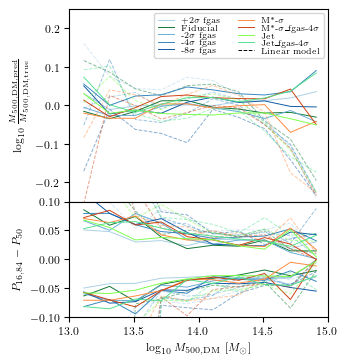

In [34]:
### save error+percentile plot
fig, axs = plt.subplots(2, 1, figsize=(10/3, 4), sharex=True, gridspec_kw={"height_ratios":(5,3),"hspace":0})
for i, testmodel in enumerate(testmodels):
    p["model"] = testmodel
    masses = np.load(p["data_path"]+p_to_filename(p)+"_masses.npy")
    testmasses = masses[:int(len(masses)*p["test_size"])]
    nr_bins = 10
    bin_edges = np.logspace(13, 15, nr_bins+1)
    
    ### 2d scaling relation
    x = np.array([])
    y = np.array([])
    perc16 = np.array([])
    perc84 = np.array([])
    for b in range(nr_bins):
        indices = np.logical_and(testmasses > bin_edges[b], testmasses < bin_edges[b+1])
        error = np.array(scaling_predictions[i])[indices] - np.log10(testmasses[indices])
        x = np.append(x, np.log10(np.mean([bin_edges[b], bin_edges[b+1]])))
        y = np.append(y, np.median(error))
        perc16 = np.append(perc16, np.percentile(error, 16))
        perc84 = np.append(perc84, np.percentile(error, 84))
    axs[0].plot(x, y, color=colors[i], ls="dashed", alpha=0.5)
    axs[1].plot(x, perc16-y, color=colors[i], linestyle="dashed", alpha=0.5)
    axs[1].plot(x, perc84-y, color=colors[i], linestyle="dashed", alpha=0.5)
    
    ### network
    x = np.array([])
    y = np.array([])
    perc16 = np.array([])
    perc84 = np.array([])
    for b in range(nr_bins):
        indices = np.logical_and(testmasses > bin_edges[b], testmasses < bin_edges[b+1])
        error = np.array(predictions[i])[indices] - np.log10(testmasses[indices])
        x = np.append(x, np.log10(np.mean([bin_edges[b], bin_edges[b+1]])))
        y = np.append(y, np.median(error))
        perc16 = np.append(perc16, np.percentile(error, 16))
        perc84 = np.append(perc84, np.percentile(error, 84))
    axs[0].plot(x, y, color=colors[i], label=names[i])
    axs[1].plot(x, perc16-y, color=colors[i])
    axs[1].plot(x, perc84-y, color=colors[i])


axs[0].set_ylabel(r"$\log_{10} \frac{M_{500, \mathrm{DM}, \mathrm{pred}}}{M_{500, \mathrm{DM}, \mathrm{true}}}$")
axs[1].set_ylabel(r"$P_{16, 84} - P_{50}$")
plt.xlabel(r"$\log_{10} M_{500, \mathrm{DM}}$  $\left[M_\odot \right]$")
plt.xlim(13, 15)

axs[0].set_ylim(-0.25, 0.25)
axs[1].set_ylim(-0.1, 0.1)

axs[0].plot([14], [0], color="black", label="Linear model", ls="dashed")
# axs[1].plot([0], [0], color="black", label="16th-84th percentiles", ls="dashdot")
axs[0].legend(loc="upper right", bbox_to_anchor=(1, 1), labelspacing=0, ncol=2)
# axs[1].legend(loc="upper right", bbox_to_anchor=(1, 1), labelspacing=0, ncol=2)

if p["noisy"]:
    name_addon = "_noisy"
else:
    name_addon = ""

plt.savefig("/home/tol/Documents/Thesis/plots/results_"+p["simtype"]+"_"+trainmodel+"_"+name_addon+".pdf", bbox_inches="tight")
plt.show()

# Generate all plots for results

In [ ]:
### Linear prediction

def powerlaw2d(xy, L0_low, p1_low, p2_low, L0_high, p1_high, p2_high, M0):
    x, y = xy
    fit_low = np.zeros(len(x))
    fit_low[x < L0_low] = p1_low * (x[x < L0_low] - L0_low)
    fit_low[x >= L0_low] = p2_low * (x[x >= L0_low] - L0_low)
    fit_high = np.zeros(len(y))
    fit_high[y < L0_high] = p1_high * (y[y < L0_high] - L0_high)
    fit_high[y >= L0_high] = p2_high * (y[y >= L0_high] - L0_high)
    return fit_low + fit_high + M0

def predict_with_scaling_relations(testmodels, verbose=False):
    ### load scaling relation for trainmodel
    p["model"] = trainmodel
    bgd = json.load(open(p["model_path"]+"bgd.json", "r"))
    bgd_low = bgd["bgd_low"] * bgd["z0"+str(p["redshift"])[2:]]["fov"]**2 * p["obs_time"] /64/64 * p["modules"] #counts / pixel
    bgd_high = bgd["bgd_high"] * bgd["z0"+str(p["redshift"])[2:]]["fov"]**2 * p["obs_time"] /64/64 * p["modules"]
    predictions = []
    for testmodel in testmodels:
        ### load images in testset
        p["model"] = testmodel
        if p["noisy"]:
            ### workaround since old convolution was wrong, so recalculate noise here
            p["noisy"] = False
            data = Data(p)
            data.load_testset(filename=p_to_filename(p))
            data.images = data.add_noise(data.images)
            p["noisy"] = True
        else:
            data = Data(p)
            data.load_testset(filename=p_to_filename(p))

        ### add pixel values within r_500
        pixel_size = 4 * 1000 / 64  #4Mpc * 1000kpc/Mpc / 64pixels
        points_low = []
        points_high = []
        for i, haloindex in enumerate(data.indices):
            r = data.soap_file[f"{data.selection_type}/SORadius"][haloindex] * 1000 #kpc
            radius = r / pixel_size
            X, Y = np.ogrid[:p['resolution'], :p['resolution']]
            dist_from_center = np.sqrt((X + 0.5-int(p['resolution']/2))**2+(Y+0.5-int(p['resolution']/2))**2)
            mask_circ = dist_from_center<=radius
            if p["noisy"]:
                ### do not allow negative values for photon counts
                luminosity_circle_low = np.log10(max(np.sum(data.images[i, 0][mask_circ] - bgd_low), 1))
                luminosity_circle_high = np.log10(max(np.sum(data.images[i, 1][mask_circ] - bgd_high), 1))
            else:
                luminosity_circle_low = np.log10(np.sum(data.images[i, 0][mask_circ]))
                luminosity_circle_high = np.log10(np.sum(data.images[i, 1][mask_circ]))

            points_low.append(luminosity_circle_low)
            points_high.append(luminosity_circle_high)
        
        ### make prediction using parameters found by scaling_relation.py
        if p["simtype"] == "single" or p["simtype"] == "all_but":
            coeffs = json.load(open(p["model_path"]+"powerlawcoeffs.json", "r"))[p["simtype"]][trainmodel]
        else:
            coeffs = json.load(open(p["model_path"]+"powerlawcoeffs.json", "r"))[p["simtype"]]
        xy = np.append(np.array(points_low)[np.newaxis, :], np.array(points_high)[np.newaxis, :], axis=0)
        predictions.append(powerlaw2d(xy, coeffs[0], coeffs[1], coeffs[2], coeffs[3], coeffs[4], coeffs[5], coeffs[6]))
        if verbose: print(f"{testmodel} done")
    return predictions
    

In [ ]:
### neural network prediction

def predict_with_nn(testmodels, verbose=False):
    p["model"] = trainmodel
    ### load normalization factors which were used during model training
    _, _, _, _, _, _, mean_x, mean_y, std_x, std_y = load_nn_dataset(p)
    predictions = []
    
    p_all = p.copy()
    p_all["simtype"] = "all"
    ### load data normalized by all images (so incorrect normalization)
    testx, _, _, _, _, _, wrong_mean_x, _, wrong_std_x, _ = load_nn_dataset(p_all)
    for i in range(len(testx)):
        with torch.no_grad():
            #scale back to normal physical values and normalize with mean and std used during training
            testset = (testx[i] * wrong_std_x[np.newaxis, :, np.newaxis, np.newaxis] + wrong_mean_x[np.newaxis, :, np.newaxis, np.newaxis] - mean_x[np.newaxis, :, np.newaxis, np.newaxis]) / std_x[np.newaxis, :, np.newaxis, np.newaxis] 
            ### make predictions
            predictions.append(nnmodel(torch.Tensor(testset)).squeeze(1) * std_y + mean_y)
        if verbose: print(f"{testmodels[i]} done")
    return predictions

test1
test 0
HYDRO_WEAK_AGN done
test 1
HYDRO_FIDUCIAL done
test 2
HYDRO_STRONG_AGN done
test 3
HYDRO_STRONGER_AGN done
test 4
HYDRO_STRONGEST_AGN done
test 5
HYDRO_STRONG_SUPERNOVA done
test 6
HYDRO_STRONGER_AGN_STRONG_SUPERNOVA done
test 7
HYDRO_JETS_published done
test 8
HYDRO_STRONG_JETS_published done
HYDRO_WEAK_AGN done
HYDRO_FIDUCIAL done
HYDRO_STRONG_AGN done
HYDRO_STRONGER_AGN done
HYDRO_STRONGEST_AGN done
HYDRO_STRONG_SUPERNOVA done
HYDRO_STRONGER_AGN_STRONG_SUPERNOVA done
HYDRO_JETS_published done
HYDRO_STRONG_JETS_published done


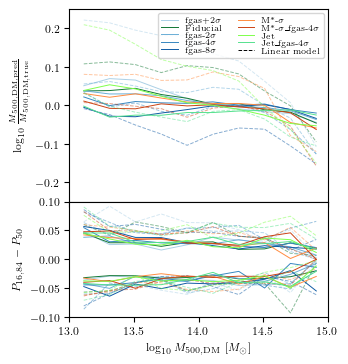

test1
test 0
HYDRO_WEAK_AGN done
test 1
HYDRO_FIDUCIAL done
test 2
HYDRO_STRONG_AGN done
test 3
HYDRO_STRONGER_AGN done
test 4
HYDRO_STRONGEST_AGN done
test 5
HYDRO_STRONG_SUPERNOVA done
test 6
HYDRO_STRONGER_AGN_STRONG_SUPERNOVA done
test 7
HYDRO_JETS_published done
test 8
HYDRO_STRONG_JETS_published done
HYDRO_WEAK_AGN done
HYDRO_FIDUCIAL done
HYDRO_STRONG_AGN done
HYDRO_STRONGER_AGN done
HYDRO_STRONGEST_AGN done
HYDRO_STRONG_SUPERNOVA done
HYDRO_STRONGER_AGN_STRONG_SUPERNOVA done
HYDRO_JETS_published done
HYDRO_STRONG_JETS_published done


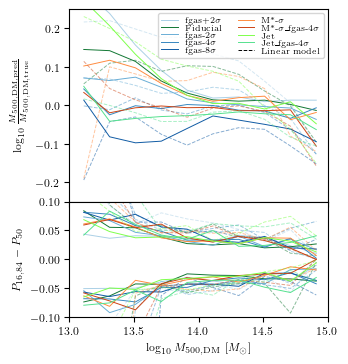

test1
test 0
HYDRO_WEAK_AGN done
test 1
HYDRO_FIDUCIAL done
test 2
HYDRO_STRONG_AGN done
test 3
HYDRO_STRONGER_AGN done
test 4
HYDRO_STRONGEST_AGN done
test 5
HYDRO_STRONG_SUPERNOVA done
test 6
HYDRO_STRONGER_AGN_STRONG_SUPERNOVA done
test 7
HYDRO_JETS_published done
test 8
HYDRO_STRONG_JETS_published done
HYDRO_WEAK_AGN done
HYDRO_FIDUCIAL done
HYDRO_STRONG_AGN done
HYDRO_STRONGER_AGN done
HYDRO_STRONGEST_AGN done
HYDRO_STRONG_SUPERNOVA done
HYDRO_STRONGER_AGN_STRONG_SUPERNOVA done
HYDRO_JETS_published done
HYDRO_STRONG_JETS_published done


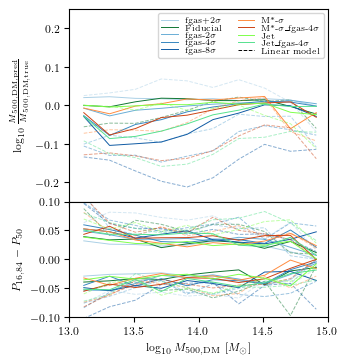

test1
test 0
HYDRO_WEAK_AGN done
test 1
HYDRO_FIDUCIAL done
test 2
HYDRO_STRONG_AGN done
test 3
HYDRO_STRONGER_AGN done
test 4
HYDRO_STRONGEST_AGN done
test 5
HYDRO_STRONG_SUPERNOVA done
test 6
HYDRO_STRONGER_AGN_STRONG_SUPERNOVA done
test 7
HYDRO_JETS_published done
test 8
HYDRO_STRONG_JETS_published done
HYDRO_WEAK_AGN done
HYDRO_FIDUCIAL done
HYDRO_STRONG_AGN done
HYDRO_STRONGER_AGN done
HYDRO_STRONGEST_AGN done
HYDRO_STRONG_SUPERNOVA done
HYDRO_STRONGER_AGN_STRONG_SUPERNOVA done
HYDRO_JETS_published done
HYDRO_STRONG_JETS_published done


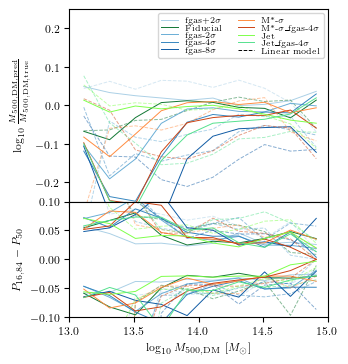

test1
test 0
HYDRO_WEAK_AGN done
test 1
HYDRO_FIDUCIAL done
test 2
HYDRO_STRONG_AGN done
test 3
HYDRO_STRONGER_AGN done
test 4
HYDRO_STRONGEST_AGN done
test 5
HYDRO_STRONG_SUPERNOVA done
test 6
HYDRO_STRONGER_AGN_STRONG_SUPERNOVA done
test 7
HYDRO_JETS_published done
test 8
HYDRO_STRONG_JETS_published done
HYDRO_WEAK_AGN done
HYDRO_FIDUCIAL done
HYDRO_STRONG_AGN done
HYDRO_STRONGER_AGN done
HYDRO_STRONGEST_AGN done
HYDRO_STRONG_SUPERNOVA done
HYDRO_STRONGER_AGN_STRONG_SUPERNOVA done
HYDRO_JETS_published done
HYDRO_STRONG_JETS_published done


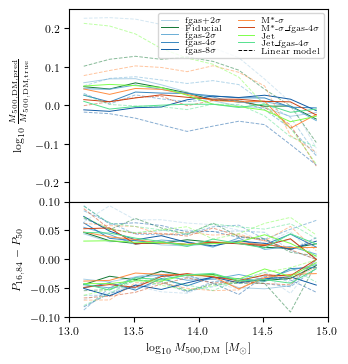

test1
test 0
HYDRO_WEAK_AGN done
test 1
HYDRO_FIDUCIAL done
test 2
HYDRO_STRONG_AGN done
test 3
HYDRO_STRONGER_AGN done
test 4
HYDRO_STRONGEST_AGN done
test 5
HYDRO_STRONG_SUPERNOVA done
test 6
HYDRO_STRONGER_AGN_STRONG_SUPERNOVA done
test 7
HYDRO_JETS_published done
test 8
HYDRO_STRONG_JETS_published done
HYDRO_WEAK_AGN done
HYDRO_FIDUCIAL done
HYDRO_STRONG_AGN done
HYDRO_STRONGER_AGN done
HYDRO_STRONGEST_AGN done
HYDRO_STRONG_SUPERNOVA done
HYDRO_STRONGER_AGN_STRONG_SUPERNOVA done
HYDRO_JETS_published done
HYDRO_STRONG_JETS_published done


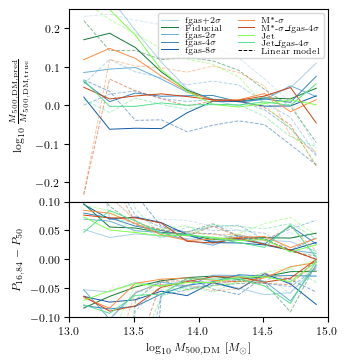

In [13]:
### same as above, but for all simulation variations and all model combinations at once

for simtype in ["single", "all", "all_but", "extremes"]:
    if simtype == "single":
        modellist = ["HYDRO_WEAK_AGN", "HYDRO_FIDUCIAL", "HYDRO_STRONG_AGN", "HYDRO_STRONGER_AGN", "HYDRO_STRONGEST_AGN", "HYDRO_STRONG_SUPERNOVA", "HYDRO_STRONGER_AGN_STRONG_SUPERNOVA", "HYDRO_JETS_published", "HYDRO_STRONG_JETS_published"]
    elif simtype == "all" or simtype == "extremes":
        modellist = ["HYDRO_FIDUCIAL"]
    elif simtype == "all_but":
        modellist == ["HYDRO_FIDUCIAL", "HYDRO_STRONG_AGN"]
    for model in modellist:
    # for model in ["HYDRO_FIDUCIAL"]:
        for noisy in [False, True]:
            trainmodel = model
            testmodels = ["HYDRO_WEAK_AGN", "HYDRO_FIDUCIAL", "HYDRO_STRONG_AGN", "HYDRO_STRONGER_AGN", "HYDRO_STRONGEST_AGN", "HYDRO_STRONG_SUPERNOVA", "HYDRO_STRONGER_AGN_STRONG_SUPERNOVA", "HYDRO_JETS_published", "HYDRO_STRONG_JETS_published"]
            colors = ['#abd0e6', '#117733','#6aaed6','#3787c0','#105ba4', '#FF8C40','#CC4314','#7EFF4B','#55E18E']
            names = [r"fgas+2$\sigma$", "Fiducial", r"fgas-2$\sigma$", r"fgas-4$\sigma$", r"fgas-8$\sigma$", r"M*-$\sigma$", r"M*-$\sigma$_fgas-4$\sigma$", r"Jet", r"Jet_fgas-4$\sigma$"]
            p["noisy"] = noisy
            p["model"] = trainmodel
            p["simtype"] = "single"
            data = Data(p)

            filename = p_to_filename(p)
            name_addon = ""
            if p["simtype"] != "single":
                name_addon += "_"+p["simtype"]
            if p["noisy"]:
                name_addon += "_noisy"
            nnmodel = torch.load(f"{p['model_path']}/{filename+name_addon}.pt", map_location=torch.device("cpu"))
            predictions = predict_with_nn(testmodels, verbose=True)
            scaling_predictions = predict_with_scaling_relations(testmodels, verbose=True)

            ### error + percentile plots
            fig, axs = plt.subplots(2, 1, figsize=(10/3, 4), sharex=True, gridspec_kw={"height_ratios":(5,3),"hspace":0})
            for i, testmodel in enumerate(testmodels):
                p["model"] = testmodel
                masses = np.load(p["data_path"]+p_to_filename(p)+"_masses.npy")
                testmasses = masses[:int(len(masses)*p["test_size"])]
                nr_bins = 10
                bin_edges = np.logspace(13, 15, nr_bins+1)
                ### 2d scaling relation
                x = np.array([])
                y = np.array([])
                perc16 = np.array([])
                perc84 = np.array([])
                for b in range(nr_bins):
                    indices = np.logical_and(testmasses > bin_edges[b], testmasses < bin_edges[b+1])
                    error = np.array(scaling_predictions[i])[indices] - np.log10(testmasses[indices])
                    x = np.append(x, np.log10(np.mean([bin_edges[b], bin_edges[b+1]])))
                    y = np.append(y, np.median(error))
                    perc16 = np.append(perc16, np.percentile(error, 16))
                    perc84 = np.append(perc84, np.percentile(error, 84))
                axs[0].plot(x, y, color=colors[i], ls="dashed", alpha=0.5)
                axs[1].plot(x, perc16-y, color=colors[i], linestyle="dashed", alpha=0.5)
                axs[1].plot(x, perc84-y, color=colors[i], linestyle="dashed", alpha=0.5)
                ### network
                x = np.array([])
                y = np.array([])
                perc16 = np.array([])
                perc84 = np.array([])
                for b in range(nr_bins):
                    indices = np.logical_and(testmasses > bin_edges[b], testmasses < bin_edges[b+1])
                    error = np.array(predictions[i])[indices] - np.log10(testmasses[indices])
                    x = np.append(x, np.log10(np.mean([bin_edges[b], bin_edges[b+1]])))
                    y = np.append(y, np.median(error))
                    perc16 = np.append(perc16, np.percentile(error, 16))
                    perc84 = np.append(perc84, np.percentile(error, 84))
                axs[0].plot(x, y, color=colors[i], label=names[i])
                axs[1].plot(x, perc16-y, color=colors[i])
                axs[1].plot(x, perc84-y, color=colors[i])


            axs[0].set_ylabel(r"$\log_{10} \frac{M_{500, \mathrm{DM}, \mathrm{pred}}}{M_{500, \mathrm{DM}, \mathrm{true}}}$")
            axs[1].set_ylabel(r"$P_{16, 84} - P_{50}$")
            plt.xlabel(r"$\log_{10} M_{500, \mathrm{DM}}$  $\left[M_\odot \right]$")
            plt.xlim(13, 15)

            axs[0].set_ylim(-0.25, 0.25)
            axs[1].set_ylim(-0.1, 0.1)

            axs[0].plot([14], [0], color="black", label="Linear model", ls="dashed")
            # axs[1].plot([0], [0], color="black", label="16th-84th percentiles", ls="dashdot")
            axs[0].legend(loc="upper right", bbox_to_anchor=(1, 1), labelspacing=0, ncol=2)
            # axs[1].legend(loc="upper right", bbox_to_anchor=(1, 1), labelspacing=0, ncol=2)

            if p["noisy"]:
                name_addon = "_noisy"
            else:
                name_addon = ""

            plt.savefig("/home/tol/Documents/Thesis/plots/results_"+p["simtype"]+"_"+trainmodel+"_"+name_addon+".pdf", bbox_inches="tight")
            plt.show()

# Test: Generate z=0.5 plot (messy)

In [17]:
### z=0.5 ###
trainmodel = "HYDRO_FIDUCIAL"
testmodels = ["HYDRO_WEAK_AGN", "HYDRO_FIDUCIAL", "HYDRO_STRONG_AGN", "HYDRO_STRONGER_AGN", "HYDRO_STRONGEST_AGN", "HYDRO_STRONG_SUPERNOVA", "HYDRO_STRONGER_AGN_STRONG_SUPERNOVA", "HYDRO_JETS_published", "HYDRO_STRONG_JETS_published"]
# colors = ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple", "tab:brown", "tab:pink", "tab:gray", "tab:olive"]
colors = ['#abd0e6', '#117733','#6aaed6','#3787c0','#105ba4', '#FF8C40','#CC4314','#7EFF4B','#55E18E']
names = [r"+2$\sigma$ fgas", "Fiducial", r"-2$\sigma$ fgas", r"-4$\sigma$ fgas", r"-8$\sigma$ fgas", r"M*-$\sigma$", r"M*-$\sigma$_fgas-4$\sigma$", r"Jet", r"Jet_fgas-4$\sigma$"]

p["redshift"] = 0.5
p["noisy"] = True
data = Data(p)

name_addon = ""
if p["simtype"] != "single":
    name_addon += "_"+p["simtype"]
if p["noisy"]:
    name_addon += "_noisy"

filename = p_to_filename(p)+name_addon
nnmodel = torch.load(f"{p['model_path']}/{filename}.pt", map_location=torch.device("cpu"))

In [18]:
def powerlaw2d(xy, L0_low, p1_low, p2_low, L0_high, p1_high, p2_high, M0):
    x, y = xy
    fit_low = np.zeros(len(x))
    fit_low[x < L0_low] = p1_low * (x[x < L0_low] - L0_low)
    fit_low[x >= L0_low] = p2_low * (x[x >= L0_low] - L0_low)
    fit_high = np.zeros(len(y))
    fit_high[y < L0_high] = p1_high * (y[y < L0_high] - L0_high)
    fit_high[y >= L0_high] = p2_high * (y[y >= L0_high] - L0_high)
    return fit_low + fit_high + M0

def predict_with_scaling_relations(testmodels, verbose=False):
    ### load scaling relation for trainmodel
    p["model"] = trainmodel
    bgd = json.load(open(p["model_path"]+"bgd.json", "r"))
    bgd_low = bgd["bgd_low"] * bgd["z0"+str(p["redshift"])[2:]]["fov"]**2 * p["obs_time"] /64/64 * p["modules"] #counts / pixel
    bgd_high = bgd["bgd_high"] * bgd["z0"+str(p["redshift"])[2:]]["fov"]**2 * p["obs_time"] /64/64 * p["modules"]
    predictions = []
    p["redshift"] = 0.15
    for testmodel in testmodels:
        ### From testset(trainingset also possible) images take luminosity within r_500crit and use it to predict mass using trainmodel scaling relation
        p["model"] = testmodel
        if p["noisy"]:
            p["noisy"] = False
            data = Data(p)
            data.load_testset(filename=p_to_filename(p))
            data.images = data.add_noise(data.images)
            p["noisy"] = True
        else:
            data = Data(p)
            data.load_testset(filename=p_to_filename(p))

        pixel_size = 4 * 1000 / 64  #4Mpc * 1000kpc/Mpc / 64pixels
        points_low = []
        points_high = []
        for i, haloindex in enumerate(data.indices):
            r = data.soap_file[f"{data.selection_type}/SORadius"][haloindex] * 1000 #kpc
            radius = r / pixel_size
            X, Y = np.ogrid[:p['resolution'], :p['resolution']]
            dist_from_center = np.sqrt((X + 0.5-int(p['resolution']/2))**2+(Y+0.5-int(p['resolution']/2))**2)
            mask_circ = dist_from_center<=radius
            if p["noisy"]:
                luminosity_circle_low = np.log10(max(np.sum(data.images[i, 0][mask_circ] - bgd_low), 1))
                luminosity_circle_high = np.log10(max(np.sum(data.images[i, 1][mask_circ] - bgd_high), 1))
            else:
                luminosity_circle_low = np.log10(np.sum(data.images[i, 0][mask_circ]))
                luminosity_circle_high = np.log10(np.sum(data.images[i, 1][mask_circ]))

            points_low.append(luminosity_circle_low)
            points_high.append(luminosity_circle_high)
        z05_coeffs = [4.29707263, -0.03724657,  0.16562797,  0.81659689,  0.16854498,  0.32539896, 13.14580283]
        xy = np.append(np.array(points_low)[np.newaxis, :], np.array(points_high)[np.newaxis, :], axis=0)
        predictions.append(powerlaw2d(xy, z05_coeffs[0], z05_coeffs[1], z05_coeffs[2], z05_coeffs[3], z05_coeffs[4], z05_coeffs[5], z05_coeffs[6]))
        if verbose: print(f"{testmodel} done")
    p["redshift"] = 0.5
    return predictions
    

In [19]:
def predict_with_nn(testmodels, verbose=False):
    p["model"] = trainmodel
    _, _, _, _, _, _, mean_x, mean_y, std_x, std_y = load_nn_dataset(p)
    predictions = []
    
    p_all = p.copy()
    p_all["redshift"] = 0.15
    p_all["simtype"] = "all"
    testx, _, _, _, _, _, wrong_mean_x, _, wrong_std_x, _ = load_nn_dataset(p_all)

    for i in range(len(testx)):
        with torch.no_grad():
            #scale back to normal values and again to nn values with mean and std using for training
            testset = (testx[i] * wrong_std_x[np.newaxis, :, np.newaxis, np.newaxis] + wrong_mean_x[np.newaxis, :, np.newaxis, np.newaxis] - mean_x[np.newaxis, :, np.newaxis, np.newaxis]) / std_x[np.newaxis, :, np.newaxis, np.newaxis] 
            predictions.append(nnmodel(torch.Tensor(testset)).squeeze(1) * std_y + mean_y)
        if verbose: print(f"{testmodels[i]} done")
    return predictions

In [20]:
predictions = predict_with_nn(testmodels, verbose=True)
scaling_predictions = predict_with_scaling_relations(testmodels, verbose=True)

HYDRO_WEAK_AGN done
HYDRO_FIDUCIAL done
HYDRO_STRONG_AGN done
HYDRO_STRONGER_AGN done
HYDRO_STRONGEST_AGN done
HYDRO_STRONG_SUPERNOVA done
HYDRO_STRONGER_AGN_STRONG_SUPERNOVA done
HYDRO_JETS_published done
HYDRO_STRONG_JETS_published done
HYDRO_WEAK_AGN done
HYDRO_FIDUCIAL done
HYDRO_STRONG_AGN done
HYDRO_STRONGER_AGN done
HYDRO_STRONGEST_AGN done
HYDRO_STRONG_SUPERNOVA done
HYDRO_STRONGER_AGN_STRONG_SUPERNOVA done
HYDRO_JETS_published done
HYDRO_STRONG_JETS_published done


In [21]:
p["redshift"] = 0.5
p["model"] = "HYDRO_FIDUCIAL"

In [22]:
def powerlaw2d(xy, L0_low, p1_low, p2_low, L0_high, p1_high, p2_high, M0):
    x, y = xy
    fit_low = np.zeros(len(x))
    fit_low[x < L0_low] = p1_low * (x[x < L0_low] - L0_low)
    fit_low[x >= L0_low] = p2_low * (x[x >= L0_low] - L0_low)
    fit_high = np.zeros(len(y))
    fit_high[y < L0_high] = p1_high * (y[y < L0_high] - L0_high)
    fit_high[y >= L0_high] = p2_high * (y[y >= L0_high] - L0_high)
    return fit_low + fit_high + M0


bgd = json.load(open(p["model_path"]+"bgd.json", "r"))
bgd_low = bgd["bgd_low"] * bgd["z0"+str(p["redshift"])[2:]]["fov"]**2 * p["obs_time"] /64/64 * p["modules"] #counts / pixel
bgd_high = bgd["bgd_high"] * bgd["z0"+str(p["redshift"])[2:]]["fov"]**2 * p["obs_time"] /64/64 * p["modules"]

if p["noisy"]:
    p["noisy"] = False
    data = Data(p)
    data.load_testset(filename=p_to_filename(p))
    data.images = data.add_noise(data.images)
    p["noisy"] = True
else:
    data = Data(p)
    data.load_testset(filename=p_to_filename(p))

pixel_size = 4 * 1000 / 64  #4Mpc * 1000kpc/Mpc / 64pixels
points_low = []
points_high = []
for i, haloindex in enumerate(data.indices):
    r = data.soap_file[f"{data.selection_type}/SORadius"][haloindex] * 1000 #kpc
    radius = r / pixel_size
    X, Y = np.ogrid[:p['resolution'], :p['resolution']]
    dist_from_center = np.sqrt((X + 0.5-int(p['resolution']/2))**2+(Y+0.5-int(p['resolution']/2))**2)
    mask_circ = dist_from_center<=radius
    if p["noisy"]:
        luminosity_circle_low = np.log10(max(np.sum(data.images[i, 0][mask_circ] - bgd_low), 1))
        luminosity_circle_high = np.log10(max(np.sum(data.images[i, 1][mask_circ] - bgd_high), 1))
    else:
        luminosity_circle_low = np.log10(np.sum(data.images[i, 0][mask_circ]))
        luminosity_circle_high = np.log10(np.sum(data.images[i, 1][mask_circ]))

    points_low.append(luminosity_circle_low)
    points_high.append(luminosity_circle_high)

z05_coeffs = [4.29707263, -0.03724657,  0.16562797,  0.81659689,  0.16854498,  0.32539896, 13.14580283]

xy = np.append(np.array(points_low)[np.newaxis, :], np.array(points_high)[np.newaxis, :], axis=0)
z05_scaling_predictions = powerlaw2d(xy, z05_coeffs[0], z05_coeffs[1], z05_coeffs[2], z05_coeffs[3], z05_coeffs[4], z05_coeffs[5], z05_coeffs[6])

In [23]:
testx, _, _, _, _, _, _, mean_y, _, std_y = load_nn_dataset(p)
print(testx[0].shape)
with torch.no_grad():
    z05_predictions = np.array(nnmodel(torch.Tensor(testx[0])).squeeze(1) * std_y + mean_y)

(662, 2, 64, 64)


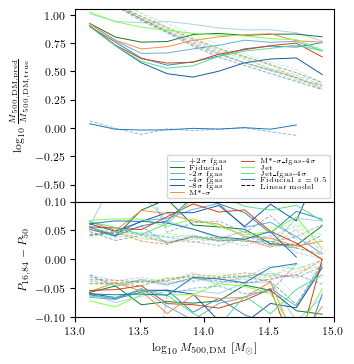

In [24]:
### error + percentile plots
fig, axs = plt.subplots(2, 1, figsize=(10/3, 4), sharex=True, gridspec_kw={"height_ratios":(5,3),"hspace":0})
p["redshift"] = 0.15
for i, testmodel in enumerate(testmodels):
    p["model"] = testmodel
    masses = np.load(p["data_path"]+p_to_filename(p)+"_masses.npy")
    testmasses = masses[:int(len(masses)*p["test_size"])]
    nr_bins = 10
    bin_edges = np.logspace(13, 15, nr_bins+1)
    ### 2d scaling relation
    x = np.array([])
    y = np.array([])
    perc16 = np.array([])
    perc84 = np.array([])
    for b in range(nr_bins):
        indices = np.logical_and(testmasses > bin_edges[b], testmasses < bin_edges[b+1])
        diff = np.array(scaling_predictions[i])[indices] - np.log10(testmasses[indices])
        x = np.append(x, np.log10(np.mean([bin_edges[b], bin_edges[b+1]])))
        y = np.append(y, np.median(diff))
        perc16 = np.append(perc16, np.percentile(diff, 16))
        perc84 = np.append(perc84, np.percentile(diff, 84))
    axs[0].plot(x, y, color=colors[i], ls="dashed", alpha=0.5)
    axs[1].plot(x, perc16-y, color=colors[i], linestyle="dashed", alpha=0.5)
    axs[1].plot(x, perc84-y, color=colors[i], linestyle="dashed", alpha=0.5)
    ### network
    x = np.array([])
    y = np.array([])
    perc16 = np.array([])
    perc84 = np.array([])
    for b in range(nr_bins):
        indices = np.logical_and(testmasses > bin_edges[b], testmasses < bin_edges[b+1])
        diff = np.array(predictions[i])[indices] - np.log10(testmasses[indices])
        x = np.append(x, np.log10(np.mean([bin_edges[b], bin_edges[b+1]])))
        y = np.append(y, np.median(diff))
        perc16 = np.append(perc16, np.percentile(diff, 16))
        perc84 = np.append(perc84, np.percentile(diff, 84))
    axs[0].plot(x, y, color=colors[i], label=names[i])
    axs[1].plot(x, perc16-y, color=colors[i])
    axs[1].plot(x, perc84-y, color=colors[i])

p["model"] = "HYDRO_FIDUCIAL"
p["redshift"] = 0.5
masses = np.load(p["data_path"]+p_to_filename(p)+"_masses.npy")
testmasses = masses[:int(len(masses)*p["test_size"])]
nr_bins = 9
bin_edges = np.logspace(13, 14.8, nr_bins+1)
### 2d scaling relation
x = np.array([])
y = np.array([])
perc16 = np.array([])
perc84 = np.array([])
for b in range(nr_bins):
    indices = np.logical_and(testmasses > bin_edges[b], testmasses < bin_edges[b+1])
    diff = np.array(z05_scaling_predictions)[indices] - np.log10(testmasses[indices])
    x = np.append(x, np.log10(np.mean([bin_edges[b], bin_edges[b+1]])))
    y = np.append(y, np.median(diff))
    perc16 = np.append(perc16, np.percentile(diff, 16))
    perc84 = np.append(perc84, np.percentile(diff, 84))
axs[0].plot(x, y, color="tab:blue", ls="dashed", alpha=0.5)
axs[1].plot(x, perc16-y, color="tab:blue", linestyle="dashed", alpha=0.5)
axs[1].plot(x, perc84-y, color="tab:blue", linestyle="dashed", alpha=0.5)
### network
x = np.array([])
y = np.array([])
perc16 = np.array([])
perc84 = np.array([])
for b in range(nr_bins):
    indices = np.logical_and(testmasses > bin_edges[b], testmasses < bin_edges[b+1])
    diff = np.array(z05_predictions)[indices] - np.log10(testmasses[indices])
    x = np.append(x, np.log10(np.mean([bin_edges[b], bin_edges[b+1]])))
    y = np.append(y, np.median(diff))
    perc16 = np.append(perc16, np.percentile(diff, 16))
    perc84 = np.append(perc84, np.percentile(diff, 84))
axs[0].plot(x, y, color="tab:blue", label="Fiducial $z=0.5$")
axs[1].plot(x, perc16-y, color="tab:blue")
axs[1].plot(x, perc84-y, color="tab:blue")

axs[0].set_ylabel(r"$\log_{10} \frac{M_{500, \mathrm{DM}, \mathrm{pred}}}{M_{500, \mathrm{DM}, \mathrm{true}}}$")
axs[1].set_ylabel(r"$P_{16, 84} - P_{50}$")
plt.xlabel(r"$\log_{10} M_{500, \mathrm{DM}}$  $\left[M_\odot \right]$")
plt.xlim(13, 15)

axs[0].set_ylim(-0.65, 1.05)
axs[1].set_ylim(-0.1, 0.1)

axs[0].plot([14], [0], color="black", label="Linear model", ls="dashed")
# axs[1].plot([0], [0], color="black", label="16th-84th percentiles", ls="dashdot")
axs[0].legend(loc="lower right", bbox_to_anchor=(1, 0), labelspacing=0, ncol=2)
# axs[1].legend(loc="upper right", bbox_to_anchor=(1, 1), labelspacing=0, ncol=2)

if p["noisy"]:
    name_addon = "_noisy"
else:
    name_addon = ""

plt.savefig("/home/tol/Documents/Thesis/plots/results_z05"+name_addon+".pdf", bbox_inches="tight")
plt.show()

(107,)
<class 'numpy.ndarray'>
(102,)
<class 'numpy.ndarray'>
(92,)
<class 'numpy.ndarray'>
(110,)
<class 'numpy.ndarray'>
(106,)
<class 'numpy.ndarray'>
(76,)
<class 'numpy.ndarray'>
(51,)
<class 'numpy.ndarray'>
(15,)
<class 'numpy.ndarray'>
(3,)
<class 'numpy.ndarray'>


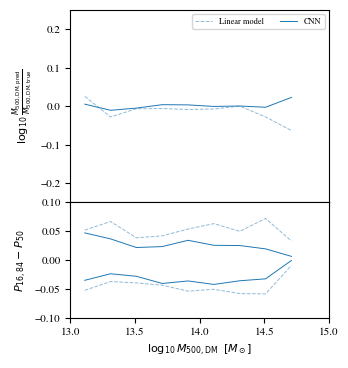

In [69]:
### error + percentile plots
fig, axs = plt.subplots(2, 1, figsize=(10/3, 4), sharex=True, gridspec_kw={"height_ratios":(5,3),"hspace":0})

masses = np.load(p["data_path"]+p_to_filename(p)+"_masses.npy")
testmasses = masses[:int(len(masses)*p["test_size"])]
nr_bins = 9
bin_edges = np.logspace(13, 14.8, nr_bins+1)
### 2d scaling relation
x = np.array([])
y = np.array([])
perc16 = np.array([])
perc84 = np.array([])
for b in range(nr_bins):
    indices = np.logical_and(testmasses > bin_edges[b], testmasses < bin_edges[b+1])
    diff = np.array(z05_scaling_predictions)[indices] - np.log10(testmasses[indices])
    x = np.append(x, np.log10(np.mean([bin_edges[b], bin_edges[b+1]])))
    y = np.append(y, np.median(diff))
    print(diff.shape)
    print(type(diff))
    perc16 = np.append(perc16, np.percentile(diff, 16))
    perc84 = np.append(perc84, np.percentile(diff, 84))
axs[0].plot(x, y, color="tab:blue", ls="dashed", alpha=0.5, label="Linear model")
axs[1].plot(x, perc16-y, color="tab:blue", linestyle="dashed", alpha=0.5)
axs[1].plot(x, perc84-y, color="tab:blue", linestyle="dashed", alpha=0.5)
### network
x = np.array([])
y = np.array([])
perc16 = np.array([])
perc84 = np.array([])
for b in range(nr_bins):
    indices = np.logical_and(testmasses > bin_edges[b], testmasses < bin_edges[b+1])
    diff = np.array(z05_predictions)[indices] - np.log10(testmasses[indices])
    x = np.append(x, np.log10(np.mean([bin_edges[b], bin_edges[b+1]])))
    y = np.append(y, np.median(diff))
    perc16 = np.append(perc16, np.percentile(diff, 16))
    perc84 = np.append(perc84, np.percentile(diff, 84))
axs[0].plot(x, y, color="tab:blue", label="CNN")
axs[1].plot(x, perc16-y, color="tab:blue")
axs[1].plot(x, perc84-y, color="tab:blue")


axs[0].set_ylabel(r"$\log_{10} \frac{M_{500, \mathrm{DM}, \mathrm{pred}}}{M_{500, \mathrm{DM}, \mathrm{true}}}$")
axs[1].set_ylabel(r"$P_{16, 84} - P_{50}$")
plt.xlabel(r"$\log_{10} M_{500, \mathrm{DM}}$  $\left[M_\odot \right]$")
plt.xlim(13, 15)

axs[0].set_ylim(-0.25, 0.25)
axs[1].set_ylim(-0.1, 0.1)

# axs[0].plot([14], [0], color="black", label="Linear model", ls="dashed")
# axs[1].plot([0], [0], color="black", label="16th-84th percentiles", ls="dashdot")
axs[0].legend(loc="upper right", bbox_to_anchor=(1, 1), labelspacing=0, ncol=2)
# axs[1].legend(loc="upper right", bbox_to_anchor=(1, 1), labelspacing=0, ncol=2)

if p["noisy"]:
    name_addon = "_noisy"
else:
    name_addon = ""

# plt.savefig("/home/tol/Documents/Thesis/plots/results_"+p["simtype"]+"_"+trainmodel+"_"+name_addon+".pdf", bbox_inches="tight")
plt.show()

# Test: low-high plot (messy)

In [164]:
# trainmodel = "HYDRO_FIDUCIAL"
# testmodels = ["HYDRO_WEAK_AGN", "HYDRO_FIDUCIAL", "HYDRO_STRONG_AGN", "HYDRO_STRONGER_AGN", "HYDRO_STRONGEST_AGN", "HYDRO_STRONG_SUPERNOVA", "HYDRO_STRONGER_AGN_STRONG_SUPERNOVA", "HYDRO_JETS_published", "HYDRO_STRONG_JETS_published"]
# # colors = ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple", "tab:brown", "tab:pink", "tab:gray", "tab:olive"]
# colors = ['#abd0e6', '#117733','#6aaed6','#3787c0','#105ba4', '#FF8C40','#CC4314','#7EFF4B','#55E18E']
# names = [r"+2$\sigma$ fgas", "Fiducial", r"-2$\sigma$ fgas", r"-4$\sigma$ fgas", r"-8$\sigma$ fgas", r"M*-$\sigma$", r"M*-$\sigma$_fgas-4$\sigma$", r"Jet", r"Jet_fgas-4$\sigma$"]

p["redshift"] = 0.15
p["noisy"] = False
p["model"] = "HYDRO_FIDUCIAL"
p["simtype"] = "single"
data = Data(p)

name_addon = ""
if p["simtype"] != "single":
    name_addon += "_"+p["simtype"]
if p["noisy"]:
    name_addon += "_noisy"
# if p["channel"] == "low" or p["channel"] == "high":
#     name_addon += "_"+p["channel"]

filename = p_to_filename(p)+name_addon
nnmodel = torch.load(f"{p['model_path']}/{filename}.pt", map_location=torch.device("cpu"))
nnmodel_low = torch.load(f"{p['model_path']}/{filename}_low.pt", map_location=torch.device("cpu"))
nnmodel_high = torch.load(f"{p['model_path']}/{filename}_high.pt", map_location=torch.device("cpu"))

def rmse(d):
    return np.sqrt(np.mean((d)**2))
def error(a):
    return np.median(a)

In [165]:
def powerlaw2d(xy, L0_low, p1_low, p2_low, L0_high, p1_high, p2_high, M0):
    x, y = xy
    fit_low = np.zeros(len(x))
    fit_low[x < L0_low] = p1_low * (x[x < L0_low] - L0_low)
    fit_low[x >= L0_low] = p2_low * (x[x >= L0_low] - L0_low)
    fit_high = np.zeros(len(y))
    fit_high[y < L0_high] = p1_high * (y[y < L0_high] - L0_high)
    fit_high[y >= L0_high] = p2_high * (y[y >= L0_high] - L0_high)
    return fit_low + fit_high + M0

def power_law(L, L0, M0, p1, p2):
    fit = L.copy()
    fit[L < L0] = p1*(L[L<L0]-L0)+M0
    fit[L >= L0] = p2*(L[L>=L0]-L0)+M0
    return fit
    # return np.append(p1*(L[L<L0]-L0)+M0, p2*(L[L>=L0]-L0)+M0)

### load scaling relation for trainmodel
p["model"] = trainmodel
bgd = json.load(open(p["model_path"]+"bgd.json", "r"))
bgd_low = bgd["bgd_low"] * bgd["z0"+str(p["redshift"])[2:]]["fov"]**2 * p["obs_time"] /64/64 * p["modules"] #counts / pixel
bgd_high = bgd["bgd_high"] * bgd["z0"+str(p["redshift"])[2:]]["fov"]**2 * p["obs_time"] /64/64 * p["modules"]


if p["noisy"]:
    p["noisy"] = False
    data = Data(p)
    data.load_testset(filename=p_to_filename(p))
    data.images = data.add_noise(data.images)
    p["noisy"] = True
else:
    data = Data(p)
    data.load_testset(filename=p_to_filename(p))

pixel_size = 4 * 1000 / 64  #4Mpc * 1000kpc/Mpc / 64pixels
points_low = []
points_high = []
for i, haloindex in enumerate(data.indices):
    r = data.soap_file[f"{data.selection_type}/SORadius"][haloindex] * 1000 #kpc
    radius = r / pixel_size
    X, Y = np.ogrid[:p['resolution'], :p['resolution']]
    dist_from_center = np.sqrt((X + 0.5-int(p['resolution']/2))**2+(Y+0.5-int(p['resolution']/2))**2)
    mask_circ = dist_from_center<=radius
    if p["noisy"]:
        luminosity_circle_low = np.log10(max(np.sum(data.images[i, 0][mask_circ] - bgd_low), 1))
        luminosity_circle_high = np.log10(max(np.sum(data.images[i, 1][mask_circ] - bgd_high), 1))
    else:
        luminosity_circle_low = np.log10(np.sum(data.images[i, 0][mask_circ]))
        luminosity_circle_high = np.log10(np.sum(data.images[i, 1][mask_circ]))

    points_low.append(luminosity_circle_low)
    points_high.append(luminosity_circle_high)

coeffs_2d = [ 5.61094425, -0.07100183,  0.13121339 , 2.70758247,  0.2641736,   0.39274363, 13.33317146]
coeffs_low = [ 4.76821967, 13.52423573,  0.39382806,  0.60663849]
coeffs_high = [ 3.61841914, 13.68229854,  0.25861861,  0.44104734]

xy = np.append(np.array(points_low)[np.newaxis, :], np.array(points_high)[np.newaxis, :], axis=0)
scaling_predictions = powerlaw2d(xy, coeffs_2d[0], coeffs_2d[1], coeffs_2d[2], coeffs_2d[3], coeffs_2d[4], coeffs_2d[5], coeffs_2d[6])
scaling_predictions_low = power_law(np.array(points_low), coeffs_low[0], coeffs_low[1], coeffs_low[2], coeffs_low[3])
scaling_predictions_high = power_law(np.array(points_high), coeffs_high[0], coeffs_high[1], coeffs_high[2], coeffs_high[3])
    

In [166]:
testx, _, _, _, _, _, mean_x, mean_y, std_x, std_y = load_nn_dataset(p)
testx = testx[0]

with torch.no_grad():
    predictions = np.array(nnmodel(torch.Tensor(testx)).squeeze(1) * std_y + mean_y)
    predictions_low = np.array(nnmodel_low(torch.Tensor(testx[:,:1,:,:])).squeeze(1) * std_y + mean_y)
    predictions_high = np.array(nnmodel_high(torch.Tensor(testx[:,1:,:,:])).squeeze(1) * std_y + mean_y)


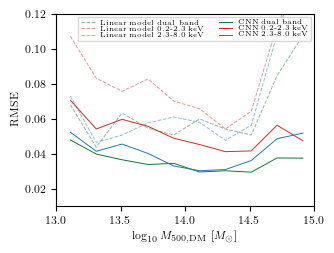

In [167]:
### error + percentile plots
# fig, axs = plt.subplots(2, 1, figsize=(10/3, 4), sharex=True, gridspec_kw={"height_ratios":(5,3),"hspace":0})
fig = plt.subplots(figsize=(10/3, 2.5))
masses = np.load(p["data_path"]+p_to_filename(p)+"_masses.npy")
testmasses = masses[:int(len(masses)*p["test_size"])]
nr_bins = 10
bin_edges = np.logspace(13, 15, nr_bins+1)
### 2d scaling relation
x = np.array([])
y = np.array([])
perc16 = np.array([])
perc84 = np.array([])
for b in range(nr_bins):
    indices = np.logical_and(testmasses > bin_edges[b], testmasses < bin_edges[b+1])
    diff = np.array(scaling_predictions)[indices] - np.log10(testmasses[indices])
    x = np.append(x, np.log10(np.mean([bin_edges[b], bin_edges[b+1]])))
    y = np.append(y, rmse(diff))
    perc16 = np.append(perc16, np.percentile(diff, 16))
    perc84 = np.append(perc84, np.percentile(diff, 84))
plt.plot(x, y, color="#117733", ls="dashed", alpha=0.5, label="Linear model dual band")
# axs[1].plot(x, perc16-y, color="#117733", linestyle="dashed", alpha=0.5)
# axs[1].plot(x, perc84-y, color="#117733", linestyle="dashed", alpha=0.5)
### 2d scaling relation
x = np.array([])
y = np.array([])
perc16 = np.array([])
perc84 = np.array([])
for b in range(nr_bins):
    indices = np.logical_and(testmasses > bin_edges[b], testmasses < bin_edges[b+1])
    diff = np.array(scaling_predictions_low)[indices] - np.log10(testmasses[indices])
    x = np.append(x, np.log10(np.mean([bin_edges[b], bin_edges[b+1]])))
    y = np.append(y, rmse(diff))
    perc16 = np.append(perc16, np.percentile(diff, 16))
    perc84 = np.append(perc84, np.percentile(diff, 84))
plt.plot(x, y, color="tab:red", ls="dashed", alpha=0.5, label="Linear model 0.2-2.3 keV")
# axs[1].plot(x, perc16-y, color="tab:red", linestyle="dashed", alpha=0.5)
# axs[1].plot(x, perc84-y, color="tab:red", linestyle="dashed", alpha=0.5)
### 2d scaling relation
x = np.array([])
y = np.array([])
perc16 = np.array([])
perc84 = np.array([])
for b in range(nr_bins):
    indices = np.logical_and(testmasses > bin_edges[b], testmasses < bin_edges[b+1])
    diff = np.array(scaling_predictions_high)[indices] - np.log10(testmasses[indices])
    x = np.append(x, np.log10(np.mean([bin_edges[b], bin_edges[b+1]])))
    y = np.append(y, rmse(diff))
    perc16 = np.append(perc16, np.percentile(diff, 16))
    perc84 = np.append(perc84, np.percentile(diff, 84))
plt.plot(x, y, color="tab:blue", ls="dashed", alpha=0.5, label="Linear model 2.3-8.0 keV")
# axs[1].plot(x, perc16-y, color="tab:blue", linestyle="dashed", alpha=0.5)
# axs[1].plot(x, perc84-y, color="tab:blue", linestyle="dashed", alpha=0.5)
### network
x = np.array([])
y = np.array([])
perc16 = np.array([])
perc84 = np.array([])
for b in range(nr_bins):
    indices = np.logical_and(testmasses > bin_edges[b], testmasses < bin_edges[b+1])
    diff = np.array(predictions)[indices] - np.log10(testmasses[indices])
    x = np.append(x, np.log10(np.mean([bin_edges[b], bin_edges[b+1]])))
    y = np.append(y, rmse(diff))
    perc16 = np.append(perc16, np.percentile(diff, 16))
    perc84 = np.append(perc84, np.percentile(diff, 84))
plt.plot(x, y, color="#117733", label="CNN dual band")
# axs[1].plot(x, perc16-y, color="#117733")
# axs[1].plot(x, perc84-y, color="#117733")
### network
x = np.array([])
y = np.array([])
perc16 = np.array([])
perc84 = np.array([])
for b in range(nr_bins):
    indices = np.logical_and(testmasses > bin_edges[b], testmasses < bin_edges[b+1])
    diff = np.array(predictions_low)[indices] - np.log10(testmasses[indices])
    x = np.append(x, np.log10(np.mean([bin_edges[b], bin_edges[b+1]])))
    y = np.append(y, rmse(diff))
    perc16 = np.append(perc16, np.percentile(diff, 16))
    perc84 = np.append(perc84, np.percentile(diff, 84))
plt.plot(x, y, color="tab:red", label="CNN 0.2-2.3 keV")
# axs[1].plot(x, perc16-y, color="tab:red")
# axs[1].plot(x, perc84-y, color="tab:red")
### network
x = np.array([])
y = np.array([])
perc16 = np.array([])
perc84 = np.array([])
for b in range(nr_bins):
    indices = np.logical_and(testmasses > bin_edges[b], testmasses < bin_edges[b+1])
    diff = np.array(predictions_high)[indices] - np.log10(testmasses[indices])
    x = np.append(x, np.log10(np.mean([bin_edges[b], bin_edges[b+1]])))
    y = np.append(y, rmse(diff))
    perc16 = np.append(perc16, np.percentile(diff, 16))
    perc84 = np.append(perc84, np.percentile(diff, 84))
plt.plot(x, y, color="tab:blue", label="CNN 2.3-8.0 keV")
# axs[1].plot(x, perc16-y, color="tab:blue")
# axs[1].plot(x, perc84-y, color="tab:blue")


# axs[0].set_ylabel(r"$\log_{10} \frac{M_{500, \mathrm{DM}, \mathrm{pred}}}{M_{500, \mathrm{DM}, \mathrm{true}}}$")
# axs[1].set_ylabel(r"$P_{16, 84} - P_{50}$")
plt.ylabel("RMSE")
plt.xlabel(r"$\log_{10} M_{500, \mathrm{DM}}$  $\left[M_\odot \right]$")
plt.xlim(13, 15)

# axs[0].set_ylim(0.01, 0.1)
# axs[1].set_ylim(-0.1, 0.1)
plt.ylim(0.01, 0.12)

# axs[0].plot([14], [0], color="black", label="Linear model", ls="dashed")
# axs[1].plot([0], [0], color="black", label="16th-84th percentiles", ls="dashdot")
plt.legend(loc="upper right", bbox_to_anchor=(1, 1), labelspacing=0, ncol=2)
# axs[1].legend(loc="upper right", bbox_to_anchor=(1, 1), labelspacing=0, ncol=2)

if p["noisy"]:
    name_addon = "_noisy"
else:
    name_addon = ""

plt.savefig("/home/tol/Documents/Thesis/plots/results_lowhigh"+name_addon+".pdf", bbox_inches="tight")
plt.show()

# Generate example images plot

In [40]:
p["redshift"] = 0.15
p["model"] = "HYDRO_FIDUCIAL"
data = Data(p)
filename = p_to_filename(p)
data.load_dataset()
print(data.images.shape)

(7359, 2, 64, 64)


In [41]:
noiseless_images = np.load(p["data_path"]+p_to_filename(p)+".npy")
noisy_images = np.load(p["data_path"]+p_to_filename(p)+"_noisy.npy")

In [ ]:
### find good examples
# for i in np.arange(0, 120):
#     plt.imshow(np.log10(noiseless_images[i, 1]))
#     plt.colorbar()
#     plt.title(f"Index {i}, mass {np.log10(data.masses[i])}")
#     plt.show()

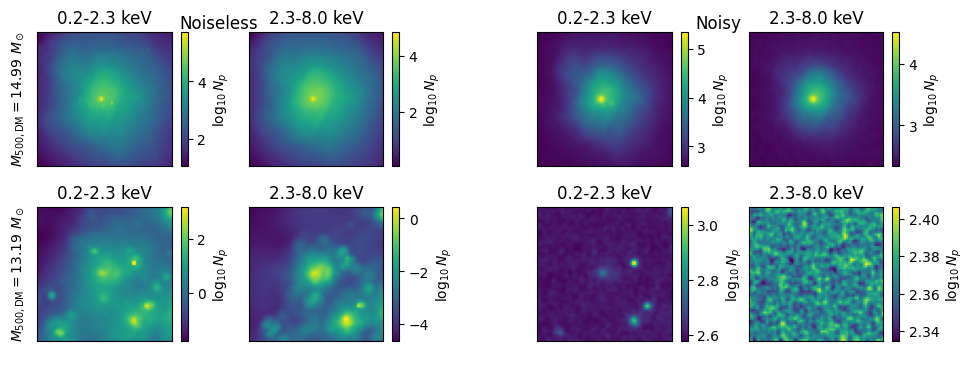

In [43]:
### nested 1x2 in 2x2 subplots
# fig, axs = plt.subplots(2, 2, figsize=(10, 3.5))
fig = plt.figure(figsize=(10, 3.5))
subfigs = fig.subfigures(2, 2)
id_large = 77
id_small = 106
indices = [id_large, id_small]
for row in range(2):
    axs_noiseless = subfigs[row, 0].subplots(1, 2)
    col1 = axs_noiseless[0].imshow(np.log10(noiseless_images[indices[row],0]))
    fig.colorbar(col1, ax=axs_noiseless[0], label=r"$\log_{10}N_p$")
    axs_noiseless[0].tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
    col2 = axs_noiseless[1].imshow(np.log10(noiseless_images[indices[row],1]))
    fig.colorbar(col2, ax=axs_noiseless[1], label=r"$\log_{10}N_p$")
    axs_noiseless[1].tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)


    axs_noisy = subfigs[row, 1].subplots(1, 2)
    col1 = axs_noisy[0].imshow(np.log10(noisy_images[indices[row],0]))
    fig.colorbar(col1, ax=axs_noisy[0], label=r"$\log_{10}N_p$")
    axs_noisy[0].tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
    col2 = axs_noisy[1].imshow(np.log10(noisy_images[indices[row],1]))
    fig.colorbar(col2, ax=axs_noisy[1], label=r"$\log_{10}N_p$")
    axs_noisy[1].tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)

    axs_noiseless[1].set_title("2.3-8.0 keV")
    axs_noiseless[0].set_title("0.2-2.3 keV")
    axs_noisy[1].set_title("2.3-8.0 keV")
    axs_noisy[0].set_title("0.2-2.3 keV")
subfigs[0, 0].suptitle("Noiseless")
subfigs[0, 1].suptitle("Noisy")
# axs[0, 0].set_ylabel(f"Mass {np.log10(data.masses[indices[0]]):.02f}"+r" $\log_{10} M_\odot$")
# axs.set_ylabel(f"Mass {np.log10(data.masses[indices[1]]):.02f}"+r" $\log_{10} M_\odot$")
# fig.text(-0.03, 0.35, f"Mass {np.log10(data.masses[indices[1]]):.02f}"+r" $\log_{10} M_\odot$", ha="center", va="center", rotation="vertical")

fig.text(0.05, 0.75, r"$M_{500, \mathrm{DM}} = $"+f"{np.log10(data.masses[id_large]):.02f}" +r"$~M_\odot$", ha="center", va="center", rotation="vertical")
fig.text(0.05, 0.25, r"$M_{500, \mathrm{DM}} = $"+f"{np.log10(data.masses[id_small]):.02f}" +r"$~M_\odot$", ha="center", va="center", rotation="vertical")
# fig.text(-0.03, 0.84, f"M {np.log10(data.masses[indices[0]]):.02f}"+r" $\log_{10} M_\odot$", ha="center", va="center", rotation="vertical")

# plt.savefig("Image comparison.pdf", bbox_inches="tight", dpi=300)
plt.show()

# Generate fiducial scaling relation plot

In [8]:
data = Data(p)

### get median binned mass per luminosity 
mass = data.soap_file[f"{p['selection_type']}/DarkMatterMass"][:]

luminosity = data.soap_file[f"{p['selection_type']}/XRayPhotonLuminosityWithoutRecentAGNHeating"][:]
mass_selection = np.logical_and(mass > 3e12, mass < 1e15)
nonzero = (np.sum(luminosity[:,:2] == 0, axis=1) == 0)

selection = mass_selection*nonzero

flux_ratio, fov = get_flux_ratio(p)

mass = mass[selection]
luminosity = luminosity[selection]*flux_ratio*p["obs_time"]
print("total nr halos in selection: ", len(mass))
print("nr inside mass selection: ", np.sum(mass_selection))
print("nr with nonzero luminosity: ", np.sum(nonzero))



bins = np.logspace(12.5, 15, 20)
masses = np.logspace(12.5, 15, 39)[1::2]

# luminosities_low = []
# luminosities_high = []
# for i in range(len(bins)-1):
#     indices = np.logical_and(mass > bins[i], mass < bins[i+1])
#     luminosities_low.append(np.median(luminosity[indices,0]))
#     luminosities_high.append(np.median(luminosity[indices,1]))


luminosities_low = []
var16_low = []
var84_low = []
luminosities_high = []
var16_high = []
var84_high = []

for i in range(len(bins)-1):
    indices = np.logical_and(mass > bins[i], mass < bins[i+1])
    luminosities_low.append(np.median(luminosity[indices,0]))
    var16_low.append(np.percentile(luminosity[indices,0], 16))
    var84_low.append(np.percentile(luminosity[indices,0], 84))
    luminosities_high.append(np.median(luminosity[indices,1]))
    var16_high.append(np.percentile(luminosity[indices,1], 16))
    var84_high.append(np.percentile(luminosity[indices,1], 84))
var16_low = np.array(luminosities_low) - np.array(var16_low)
var84_low = np.array(var84_low) - np.array(luminosities_low)
var16_high = np.array(luminosities_high) - np.array(var16_high)
var84_high = np.array(var84_high) - np.array(luminosities_high)
error_low = np.append(var16_low[np.newaxis, :], var84_low[np.newaxis, :], axis=0)
error_high = np.append(var16_high[np.newaxis, :], var84_high[np.newaxis, :], axis=0)

total nr halos in selection:  273309
nr inside mass selection:  296780
nr with nonzero luminosity:  563750


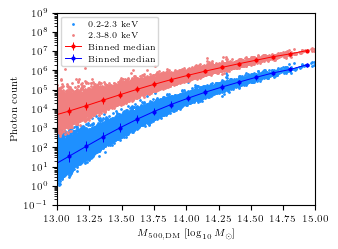

In [9]:
fig = plt.subplots(figsize=(10/3, 2.5))
plt.scatter(np.log10(mass), luminosity[:, 1], s=1, c="dodgerblue", alpha=1, label="0.2-2.3 keV")
plt.scatter(np.log10(mass), luminosity[:, 0], s=1, c="lightcoral", alpha=1, label="2.3-8.0 keV")

plt.errorbar(np.log10(masses), luminosities_low, yerr=error_low, c="red", markersize=2, marker="o", label="Binned median")
plt.errorbar(np.log10(masses), luminosities_high, yerr=error_high, c="blue", markersize=2, marker="o", label="Binned median")
plt.ylim(1e-1, 1e9)
plt.xlim(13, 15)
# plt.xscale("log")
plt.yscale("log")
plt.xlabel("$M_{500, \mathrm{DM}}~[\log_{10}M_\odot]$")
plt.ylabel("Photon count")
plt.legend()
plt.savefig("scaling_relation_example", dpi=400, bbox_inches="tight")
plt.show()

# Generate loss curve plot

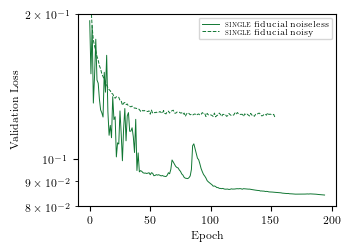

In [4]:
import json
plt.figure(figsize=(10/3, 2.5))

### single model
simtype = ""
p["model"]="HYDRO_FIDUCIAL"
params = json.load(open(p["model_path"]+p_to_filename(p)+".json", "r"))
plt.plot(range(len(params["vallosses"])), params["vallosses"], color="#117733", label=r"\textsc{single} fiducial noiseless")
params = json.load(open(p["model_path"]+p_to_filename(p)+"_noisy.json", "r"))
plt.plot(range(len(params["vallosses"])), params["vallosses"], color="#117733", label=r"\textsc{single} fiducial noisy", linestyle="dashed")

### all model
# simtype = "_all"
# params = json.load(open(p["model_path"]+p_to_filename(p)+"_all.json", "r"))
# plt.plot(range(len(params["vallosses"])), params["vallosses"], color="tab:orange", label="All")
# params = json.load(open(p["model_path"]+p_to_filename(p)+"_all_noisy.json", "r"))
# plt.plot(range(len(params["vallosses"])), params["vallosses"], color="tab:orange", linestyle="dashed")

### all but model
# simtype = "_all_but"
# params = json.load(open(p["model_path"]+p_to_filename(p)+"_all_but.json", "r"))
# plt.plot(range(len(params["vallosses"])), params["vallosses"], color="tab:red", label="All but")
# params = json.load(open(p["model_path"]+p_to_filename(p)+"_all_but_noisy.json", "r"))
# plt.plot(range(len(params["vallosses"])), params["vallosses"], color="tab:red", linestyle="dashed")

### extremes model
# simtype = "_extremes" 
# params = json.load(open(p["model_path"]+p_to_filename(p)+"_extremes.json", "r"))
# plt.plot(range(len(params["vallosses"])), params["vallosses"], color="tab:blue", label="Extremes")
# params = json.load(open(p["model_path"]+p_to_filename(p)+"_extremes_noisy.json", "r"))
# plt.plot(range(len(params["vallosses"])), params["vallosses"], color="tab:blue", linestyle="dashed")


plt.xlabel("Epoch")
plt.ylabel("Validation Loss")
plt.ylim(0.08, .2)
plt.yscale("log")
plt.legend(loc="upper right", bbox_to_anchor=(1, 1), labelspacing=0)
# plt.savefig("loss_curve.pdf", bbox_inches="tight")
plt.show()

# Generate mass distribution plot

[13.  13.1 13.2 13.3 13.4 13.5 13.6 13.7 13.8 13.9 14.  14.1 14.2 14.3
 14.4 14.5 14.6 14.7 14.8 14.9 15. ]


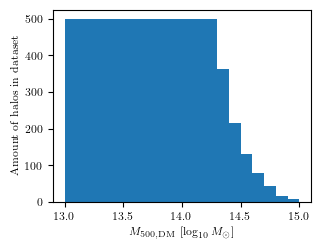

In [15]:
data = Data(p)
data.load_dataset(p_to_filename(p))
logbins = np.linspace(13, 15, 21)
print(logbins)
fig = plt.subplots(figsize=(10/3, 2.5))
plt.hist(np.log10(data.masses), bins = logbins)
plt.xlabel("$M_{500, \mathrm{DM}}~[\log_{10}M_\odot]$")
plt.ylabel("Amount of halos in dataset")
plt.savefig("mass_distribution.pdf", bbox_inches="tight")
plt.show()

# Print hyperparam table latex

In [23]:
import json
table = np.zeros((11, 10))


p["model"] = "HYDRO_FIDUCIAL"
p["simtype"] = "single"
params = json.load(open(p["model_path"]+p_to_filename(p)+f".json", "r"))
table[:, 0] = [params["conv_layers"], params["convs_per_layer"], params["base_filters"], params["kernel_size"], params["dropout"], params["use_batch_norm"], params["lr"], params["batch_size"], params["L2"], params["leaky_slope"], params["bn_momentum"]]
p["model"] = "HYDRO_STRONGEST_AGN"
p["simtype"] = "single"
params = json.load(open(p["model_path"]+p_to_filename(p)+f".json", "r"))
table[:, 1] = [params["conv_layers"], params["convs_per_layer"], params["base_filters"], params["kernel_size"], params["dropout"], params["use_batch_norm"], params["lr"], params["batch_size"], params["L2"], params["leaky_slope"], params["bn_momentum"]]
p["model"] = "HYDRO_FIDUCIAL"
p["simtype"] = "all"
params = json.load(open(p["model_path"]+p_to_filename(p)+f".json", "r"))
table[:, 2] = [params["conv_layers"], params["convs_per_layer"], params["base_filters"], params["kernel_size"], params["dropout"], params["use_batch_norm"], params["lr"], params["batch_size"], params["L2"], params["leaky_slope"], params["bn_momentum"]]
p["model"] = "HYDRO_FIDUCIAL"
p["simtype"] = "all_but"
params = json.load(open(p["model_path"]+p_to_filename(p)+f".json", "r"))
table[:, 3] = [params["conv_layers"], params["convs_per_layer"], params["base_filters"], params["kernel_size"], params["dropout"], params["use_batch_norm"], params["lr"], params["batch_size"], params["L2"], params["leaky_slope"], params["bn_momentum"]]
p["model"] = "HYDRO_FIDUCIAL"
p["simtype"] = "extremes"
params = json.load(open(p["model_path"]+p_to_filename(p)+f".json", "r"))
table[:, 4] = [params["conv_layers"], params["convs_per_layer"], params["base_filters"], params["kernel_size"], params["dropout"], params["use_batch_norm"], params["lr"], params["batch_size"], params["L2"], params["leaky_slope"], params["bn_momentum"]]

p["noisy"] = True

p["model"] = "HYDRO_FIDUCIAL"
p["simtype"] = "single"
params = json.load(open(p["model_path"]+p_to_filename(p)+f"_noisy.json", "r"))
table[:, 5] = [params["conv_layers"], params["convs_per_layer"], params["base_filters"], params["kernel_size"], params["dropout"], params["use_batch_norm"], params["lr"], params["batch_size"], params["L2"], params["leaky_slope"], params["bn_momentum"]]
p["model"] = "HYDRO_STRONGEST_AGN"
p["simtype"] = "single"
params = json.load(open(p["model_path"]+p_to_filename(p)+f"_noisy.json", "r"))
table[:, 6] = [params["conv_layers"], params["convs_per_layer"], params["base_filters"], params["kernel_size"], params["dropout"], params["use_batch_norm"], params["lr"], params["batch_size"], params["L2"], params["leaky_slope"], params["bn_momentum"]]
p["model"] = "HYDRO_FIDUCIAL"
p["simtype"] = "all"
params = json.load(open(p["model_path"]+p_to_filename(p)+f"_noisy.json", "r"))
table[:, 7] = [params["conv_layers"], params["convs_per_layer"], params["base_filters"], params["kernel_size"], params["dropout"], params["use_batch_norm"], params["lr"], params["batch_size"], params["L2"], params["leaky_slope"], params["bn_momentum"]]
p["model"] = "HYDRO_FIDUCIAL"
p["simtype"] = "all_but"
params = json.load(open(p["model_path"]+p_to_filename(p)+f"_noisy.json", "r"))
table[:, 8] = [params["conv_layers"], params["convs_per_layer"], params["base_filters"], params["kernel_size"], params["dropout"], params["use_batch_norm"], params["lr"], params["batch_size"], params["L2"], params["leaky_slope"], params["bn_momentum"]]
p["model"] = "HYDRO_FIDUCIAL"
p["simtype"] = "extremes"
params = json.load(open(p["model_path"]+p_to_filename(p)+f"_noisy.json", "r"))
table[:, 9] = [params["conv_layers"], params["convs_per_layer"], params["base_filters"], params["kernel_size"], params["dropout"], params["use_batch_norm"], params["lr"], params["batch_size"], params["L2"], params["leaky_slope"], params["bn_momentum"]]
 

In [53]:
print(table)

[[3.00000000e+00 3.00000000e+00 3.00000000e+00 3.00000000e+00
  3.00000000e+00 3.00000000e+00 3.00000000e+00 3.00000000e+00
  3.00000000e+00 3.00000000e+00]
 [2.00000000e+00 2.00000000e+00 2.00000000e+00 2.00000000e+00
  2.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
  1.00000000e+00 1.00000000e+00]
 [3.20000000e+01 3.20000000e+01 3.20000000e+01 3.20000000e+01
  3.20000000e+01 6.40000000e+01 1.60000000e+01 6.40000000e+01
  6.40000000e+01 6.40000000e+01]
 [3.00000000e+00 5.00000000e+00 3.00000000e+00 3.00000000e+00
  3.00000000e+00 3.00000000e+00 5.00000000e+00 3.00000000e+00
  3.00000000e+00 3.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 4.00000000e-01 1.00000000e-01 4.00000000e-01
  4.00000000e-01 4.00000000e-01]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [2.97517236e-04 5.65386939e-05 2.97517236e-04 2.97517236e

In [58]:
for i in range(11):
    print(" & ", end="")
    for j in range(10):
        if i==0 or i==1 or i==2 or i==3 or i==7:
            print(f"{int(table[i, j])}", end="")
        if i==4 or i==9:
            print(f"{table[i, j]}", end="")
        if i==5:
            if table[i, j]:
                print("True", end="")
            else:
                print("False", end="")
        if i==6 or i==8 or i==10:
            print(f"{table[i, j]:1.2E}", end="")
        if j != 9:
            print(" & ", end="")
        else:
            print(" \\\ ")

 & 3 & 3 & 3 & 3 & 3 & 3 & 3 & 3 & 3 & 3 \\ 
 & 2 & 2 & 2 & 2 & 2 & 1 & 1 & 1 & 1 & 1 \\ 
 & 32 & 32 & 32 & 32 & 32 & 64 & 16 & 64 & 64 & 64 \\ 
 & 3 & 5 & 3 & 3 & 3 & 3 & 5 & 3 & 3 & 3 \\ 
 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.4 & 0.1 & 0.4 & 0.4 & 0.4 \\ 
 & False & False & False & False & False & False & False & False & False & False \\ 
 & 2.98E-04 & 5.65E-05 & 2.98E-04 & 2.98E-04 & 2.98E-04 & 1.50E-05 & 2.09E-04 & 1.50E-05 & 1.50E-05 & 1.50E-05 \\ 
 & 64 & 128 & 64 & 64 & 64 & 128 & 256 & 128 & 128 & 128 \\ 
 & 2.22E-03 & 1.02E-03 & 2.22E-03 & 2.22E-03 & 2.22E-03 & 4.38E-03 & 5.93E-03 & 4.38E-03 & 4.38E-03 & 4.38E-03 \\ 
 & 0.03 & 0.1 & 0.03 & 0.03 & 0.03 & 0.0 & 0.1 & 0.0 & 0.0 & 0.0 \\ 
 & 1.53E-01 & 4.11E-02 & 1.53E-01 & 1.53E-01 & 1.53E-01 & 3.95E-03 & 2.32E-03 & 3.95E-03 & 3.95E-03 & 3.95E-03 \\ 


# Test: gas fractions

In [29]:
testmodels = ["HYDRO_WEAK_AGN", "HYDRO_FIDUCIAL", "HYDRO_STRONG_AGN", "HYDRO_STRONGER_AGN", "HYDRO_STRONGEST_AGN", "HYDRO_STRONG_SUPERNOVA", "HYDRO_STRONGER_AGN_STRONG_SUPERNOVA", "HYDRO_JETS_published", "HYDRO_STRONG_JETS_published"]
colors = ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple", "tab:brown", "tab:pink", "tab:gray", "tab:olive"]
names = [r"+2$\sigma$ fgas", "Fiducial", r"-2$\sigma$ fgas", r"-4$\sigma$ fgas", r"-8$\sigma$ fgas", r"M*-$\sigma$", r"M*-$\sigma$_fgas-4$\sigma$", r"Jet", r"Jet_fgas-4$\sigma$"]
gasfracs = []
for k, model in enumerate(testmodels):
    p["model"] = model
    data = Data(p)
    mass = data.soap_file[p["selection_type"]+"/DarkMatterMass"][:]
    
    bins = np.logspace(13, 15, 20)
    masses = np.logspace(13, 15, 39)[1::2]

    gasfrac = []

    for i in range(len(bins)-1):
        indices = np.logical_and(mass > bins[i], mass < bins[i+1])
        gasfrac.append(np.sum(data.soap_file[p["selection_type"]+"/GasMass"][indices])/np.sum(data.soap_file[p["selection_type"]+"/TotalMass"][indices]))
    gasfracs.append(np.array(gasfrac))
    # plt.plot(np.log10(masses), gasfrac, label=names[k], color=colors[k])
# plt.xlim(13, 15)
# plt.ylim(0, 0.15)
# plt.legend()
# plt.show()

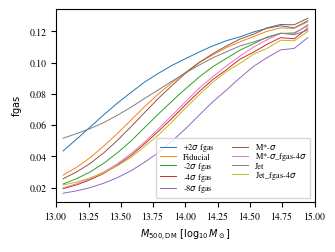

In [31]:
fig = plt.subplots(figsize=(10/3, 2.5))
# print(gasfracs)
# print(np.log10(masses))
for i in range(len(gasfracs)):
    plt.plot(np.log10(masses), gasfracs[i], label=names[i], color=colors[i])
plt.xlim(13, 15)
plt.legend(loc="lower right", bbox_to_anchor=(1, 0), labelspacing=-0.1, ncol=2)
plt.xlabel(r"$M_{500, \mathrm{DM}}~[\log_{10}M_\odot]$")
plt.ylabel(r"$\mathrm{fgas}$")
# plt.savefig("fgas.pdf", bbox_inches="tight")
plt.show()

# fig = plt.subplots(figsize=(10/3, 2.5))
# for i in range(len(gasfracs)):
#     plt.plot(np.log10(masses), gasfracs[i] / gasfracs[1], label=names[i], color=colors[i])
# plt.xlim(13, 15)
# plt.legend(loc="upper right", bbox_to_anchor=(1, 1), labelspacing=-0.1, ncol=2)
# plt.xlabel(r"$M_{500, \mathrm{tot}}~[\log_{10}M_\odot]$")
# plt.ylabel(r"$\frac{\mathrm{fgas_{variation}}}{\mathrm{fgas_{fiducial}}}$")

# # plt.savefig("fgas_relative_to_fiducial.pdf", bbox_inches="tight")
# plt.show()

# Test: Param search networks exploration

['obs_model_2chanbyhand25.json', 'obs_model_2chanbyhand6.json', 'obs_model_2chanbyhand23.json', 'obs_model_2chanbyhand3.json', 'obs_model_2chanbyhand19.json', 'obs_model_2chanbyhand12.json', 'obs_model_2chanbyhand1.json', 'obs_model_2chanbyhand13.json', 'obs_model_2chanbyhand14.json', 'obs_model_2chanbyhand4.json', 'obs_model_2chanbyhand32.json', 'obs_model_2chanbyhand7.json', 'obs_model_2chanbyhand29.json', 'obs_model_2chanbyhand31.json', 'obs_model_2chanbyhand27.json', 'obs_model_2chanbyhand11.json', 'obs_model_2chanbyhand26.json', 'obs_model_2chanbyhand28.json', 'obs_model_2chanbyhand18.json', 'obs_model_2chanbyhand20.json', 'obs_model_2chanbyhand2.json', 'obs_model_2chanbyhand8.json', 'obs_model_2chanbyhand17.json', 'obs_model_2chanbyhand21.json', 'obs_model_2chanbyhand10.json', 'obs_model_2chanbyhand24.json', 'obs_model_2chanbyhand15.json', 'obs_model_2chanbyhand30.json', 'obs_model_2chanbyhand5.json']
obs_model_2chanbyhand25.json 0.011247528716921806
obs_model_2chanbyhand6.json 0

Text(0.5, 1.0, 'Validation loss curves for all networks')

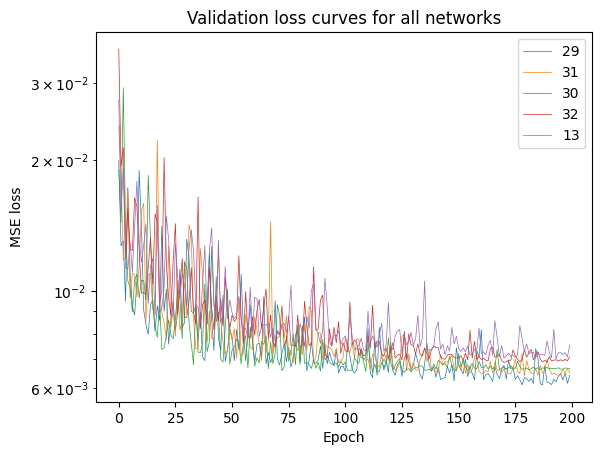

In [90]:
from os import listdir
import json

flist = listdir(p["model_path"]+"paramSearchByHand/")

files = []
for file in flist:
    if ".json" in file:
        files.append(file)
    
print(files)
vallosses = []
best = 1000.0
fig, ax = plt.subplots()
for modelname in files:
    filepath = open(p['model_path']+"paramSearchByHand/" + modelname, 'r')
    d = json.load(filepath)
    vallosses.append(np.min(d["vallosses"]))
    if d["vallosses"][-1] < best:
        best = d["vallosses"][-1]
        print(modelname, best)
    # modelnr = int(modelname[21:-5])
    # ax.plot(range(d["nr_epochs"]), d["vallosses"], label=modelnr, lw=0.5)

for i in np.argsort(vallosses)[:5]:
    print(files[i])

    filepath = open(p['model_path']+"paramSearchByHand/" + files[i], 'r')
    d = json.load(filepath)

#     # c = "blue" if d["use_batch_norm"] else "red"
#     # l = "Batch Norm" if d["use_batch_norm"] else "No Batch Norm"

    modelnr = int(files[i][21:-5])
    ax.plot(range(d["nr_epochs"]), d["vallosses"], label=modelnr, lw=0.5)
ax.set_yscale("log")
ax.set_xlabel("Epoch")
ax.set_ylabel("MSE loss")
# ax.set_ylim(7e-3, 1e-2)
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
plt.title("Validation loss curves for all networks")
# plt.savefig(p["data_path"] + "plots/loss_use_batch_norm", dpi=300)

# Test: prediction exploration

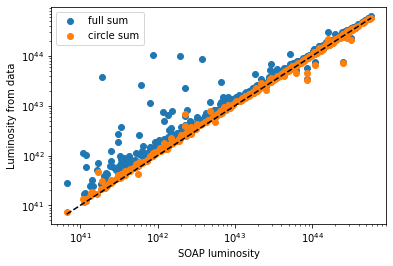

In [39]:
lums = data.soap_file[f"{data.selection_type}/XRayLuminosityWithoutRecentAGNHeating"][indices][:int(len(indices)*data.test_size), 0]

pixel_size = 2 * 2000 / 64  #kpc
lums_circle = []
for i, haloindex in enumerate(indices[:int(len(indices)*data.test_size)]):
    r = data.soap_file[f"{data.selection_type}/SORadius"][haloindex] * 1000 #kpc
    radius = r / pixel_size
    X, Y = np.ogrid[:resolution, :resolution]
    dist_from_center = np.sqrt((X + 0.5-int(resolution/2))**2+(Y+0.5-int(resolution/2))**2)
    mask_outer = dist_from_center<=radius
    lums_circle.append(np.sum(images[i, 0][mask_outer]))

plt.scatter(lums, np.sum(images[:,0,:,:], axis=(1, 2)), label="full sum")
plt.scatter(lums, lums_circle, label="circle sum")
diag = np.linspace(np.min(lums), np.max(lums), 20)
plt.plot(diag, diag, color="black", ls="dashed")
plt.xlabel("SOAP luminosity")
plt.ylabel("Luminosity from data")
# plt.title("Sum over pixels within SORadius")
plt.legend()
plt.xscale("log")
plt.yscale("log")
plt.show()



# Test: simulation exploration


[13.  13.1 13.2 13.3 13.4 13.5 13.6 13.7 13.8 13.9 14.  14.1 14.2 14.3
 14.4 14.5 14.6 14.7 14.8 14.9 15. ]


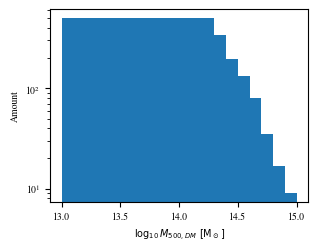

In [65]:
data = Data(p)
data.load_dataset(p_to_filename(p))
logbins = np.linspace(13, 15, 21)
print(logbins)
plt.figure(figsize=(10/3, 2.5))
plt.hist(np.log10(data.masses), bins = logbins)
plt.xlabel(r"$\log_{10} M_{500, DM}~[\mathrm{M}_\odot]$")
plt.ylabel("Amount")
plt.yscale("log")
plt.savefig("mass_distribution.pdf", dpi=200, bbox_inches="tight")
plt.show()

In [4]:
soap_path = "halo_properties_0077.hdf5"
data = Data(p)

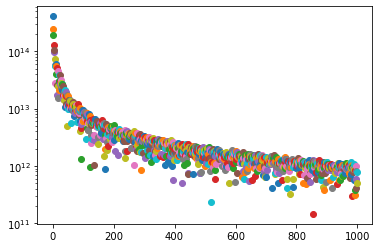

In [8]:
for i, mass in enumerate(data.soap_file[f"{p['selection_type']}/DarkMatterMass"][:10000:10]):
    plt.scatter(i, mass)
plt.yscale("log")
plt.show()

KeyError: 'Unable to synchronously open object (component not found)'

[1.00126345e+11 1.62548522e+11 2.63886813e+11 4.28402849e+11
 6.95483792e+11 1.12907210e+12 1.83297414e+12 2.97571272e+12
 4.83087349e+12 7.84260473e+12 1.27319519e+13 2.06694848e+13
 3.35555464e+13 5.44752181e+13 8.84369263e+13 1.43571521e+14
 2.33078903e+14 3.78388238e+14 6.14288367e+14 9.97256679e+14]


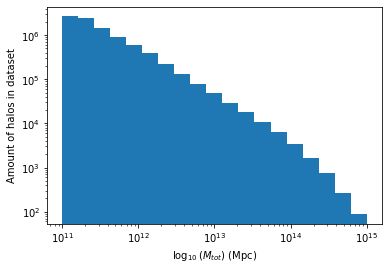

In [23]:
mass = data.soap_file[f"{p['selection_type']}/DarkMatterMass"][:]
mass = mass[np.logical_and(np.logical_and(mass > 1e11, mass !=0), mass < 1e15)]
bins = np.logspace(np.log10(np.min(mass)), np.log10(np.max(mass)), 20)
print(bins)
ret = plt.hist(mass, bins=bins)
plt.xscale("log")
plt.yscale("log")
plt.ylabel("Amount of halos in dataset")
plt.xlabel("$\log_{10}(M_{tot})$ (Mpc)")
plt.show()

In [24]:
print(ret)

(array([2.658175e+06, 2.436279e+06, 1.443613e+06, 8.889650e+05,
       5.937730e+05, 3.860400e+05, 2.274540e+05, 1.318370e+05,
       7.770900e+04, 4.786600e+04, 2.939100e+04, 1.817200e+04,
       1.072000e+04, 6.328000e+03, 3.430000e+03, 1.670000e+03,
       7.550000e+02, 2.690000e+02, 8.800000e+01]), array([1.00126345e+11, 1.62548522e+11, 2.63886813e+11, 4.28402849e+11,
       6.95483792e+11, 1.12907210e+12, 1.83297414e+12, 2.97571272e+12,
       4.83087349e+12, 7.84260473e+12, 1.27319519e+13, 2.06694848e+13,
       3.35555464e+13, 5.44752181e+13, 8.84369263e+13, 1.43571521e+14,
       2.33078903e+14, 3.78388238e+14, 6.14288367e+14, 9.97256679e+14]), <BarContainer object of 19 artists>)


# Test: dataset exploration

In [48]:
p["noisy"] = False
p["model"] = "HYDRO_FIDUCIAL"
data = Data(p)
data.load_testset(filename=p_to_filename(p))

In [52]:
print(scaling_predictions[1].shape)
print(data.masses.shape)
sorted_indices = np.argsort(np.abs(scaling_predictions[1] - np.log10(data.masses)))

(735,)
(735,)


In [53]:
print(sorted_indices)

[694 393 637 203  29 578 117 311 625 586 435 730  76 291  24 211  85 704
 469 706 316 438 119 283  99 554 451 594 265 270 299  93 255 338 647 206
 545 456 408 483 698 276   7 693 618 466 340 261 368 522 474 464  33 688
 634  49 678   4 148 705 690 405 470 339 403 337 521 457 685 505 230 195
 108 724 175 600 209 726  38 442 174  35  42 105 459 560 164   0 126 176
 462  96 429 196  41 682 247 297 381 120 289   5 102 258  74 663 670  89
 275 272 454 534  45 328 598 333 334 305 648 428 356 691 226  27  69 636
 515 201 649 539 673  63 450 248  15 279 455 689 191  19 369  66 558 163
 378 713 507 719 721 731 205 472 155 219   1 156 481  82 478 402 233 362
 571 667 376 556 400 243 732 379 484 202  71 445 421 733 605 671 387 614
 363 367 550 284  58 115 160 609 423 145 154 570 282 568 162 391 130  81
 657 714 613 392 182 251 390 535 142 409 301 244 256  50  65 458 585 133
 332 549  44  79 330 441 468 544 699 677 221 370 314 646 257 563 253 453
 241 425 268 712 696 179 288 656 526 440 703 419  8

14.524258419315055
14.5346575


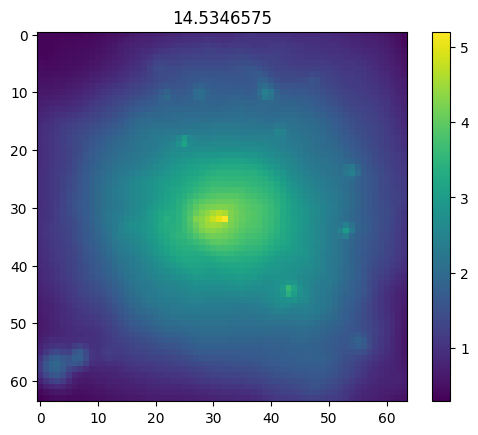

In [88]:
# i = np.argmax(np.abs(scaling_predictions[1] - np.log10(data.masses)))
i = sorted_indices[107]
print(scaling_predictions[1][i])
print(np.log10(data.masses)[i])
plt.imshow(np.log10(data.images[i, 0]))
plt.colorbar()
plt.title(np.log10(data.masses[i]))
plt.show()

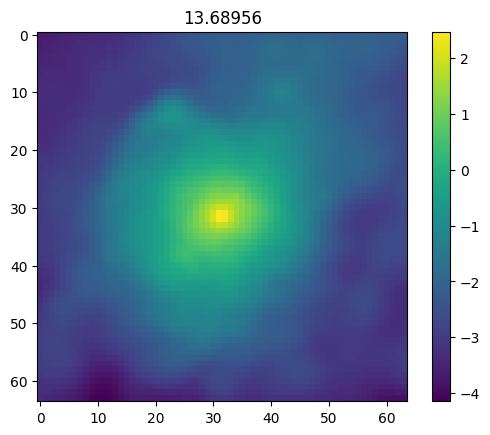

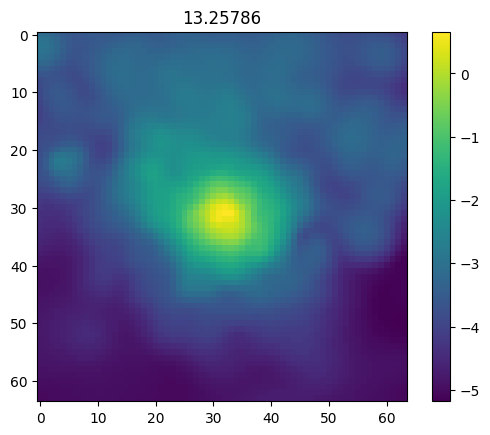

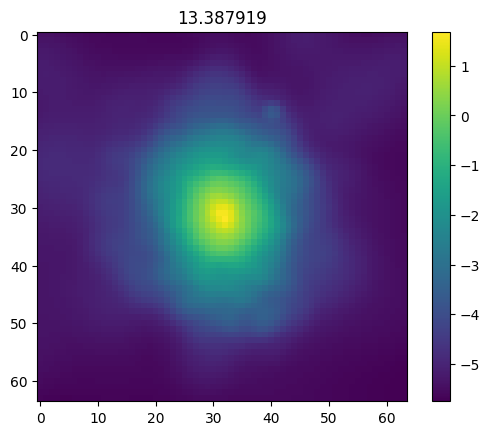

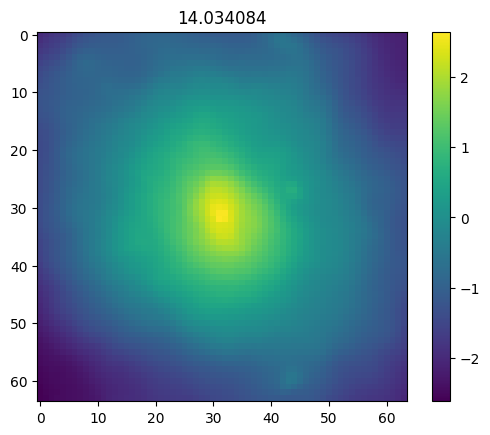

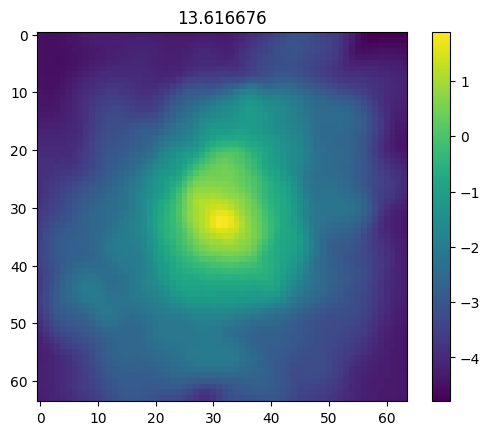

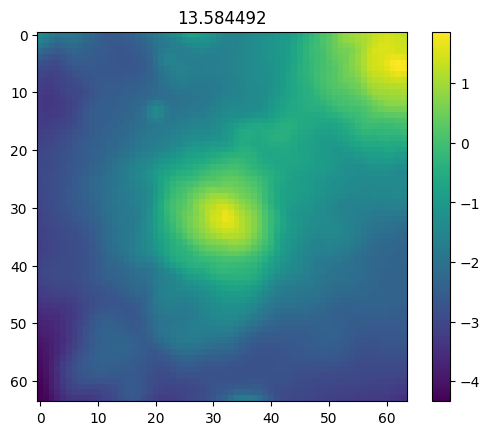

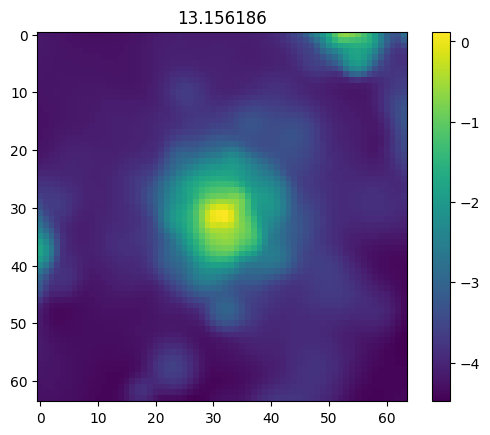

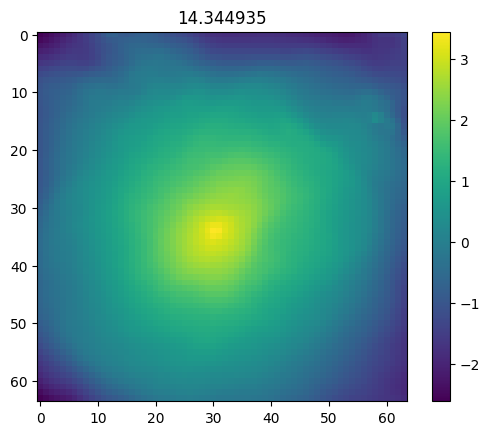

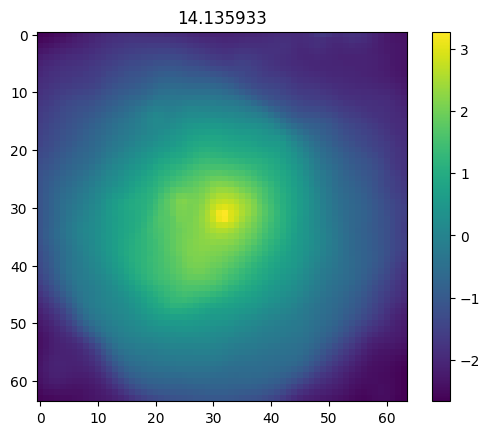

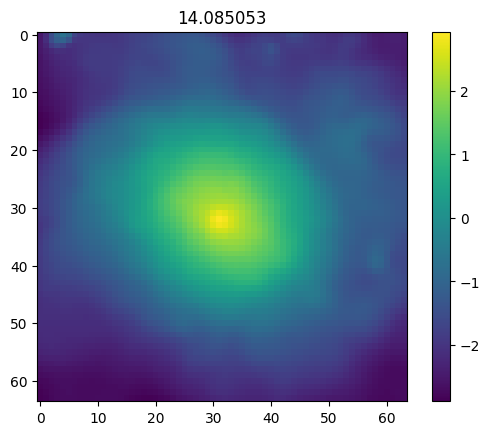

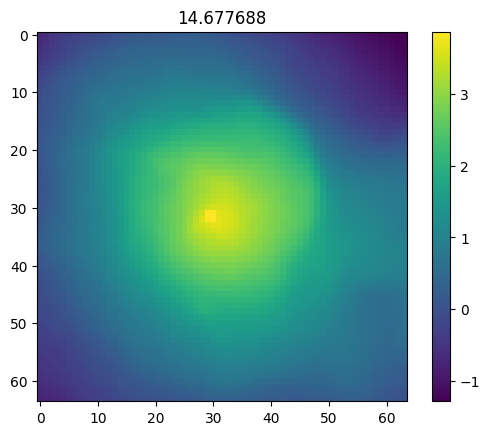

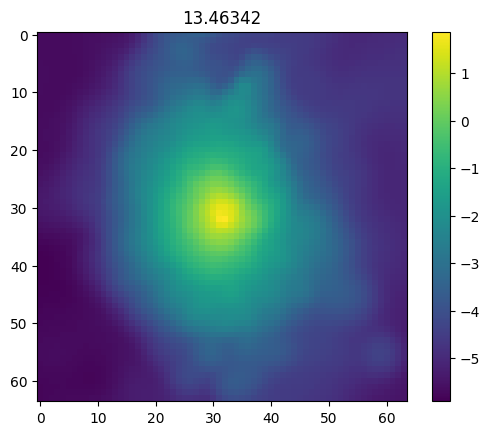

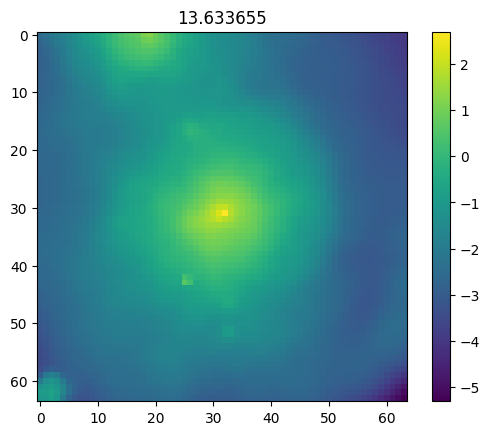

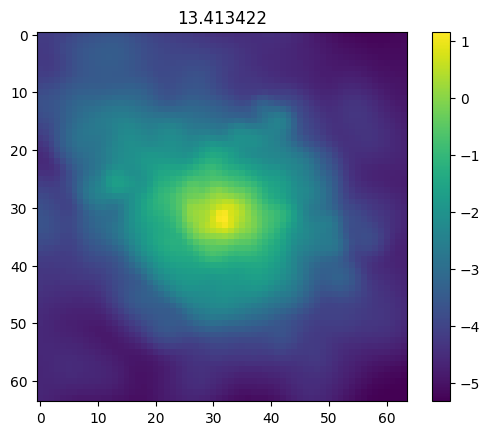

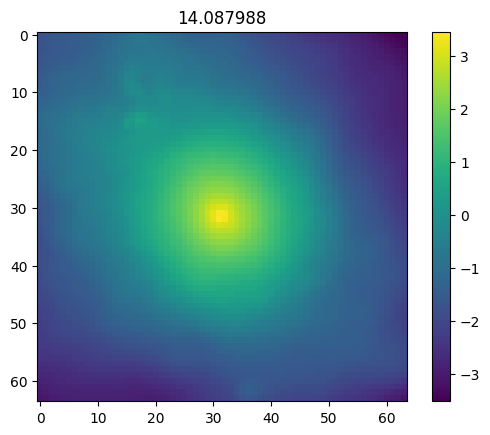

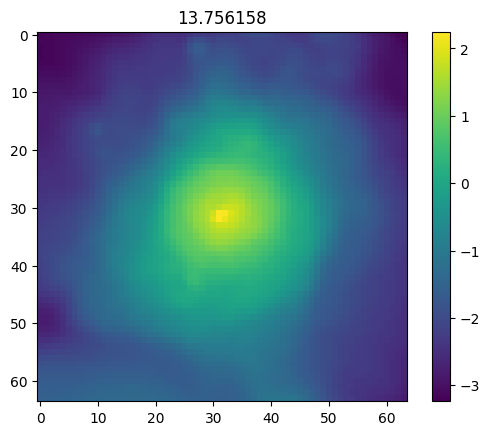

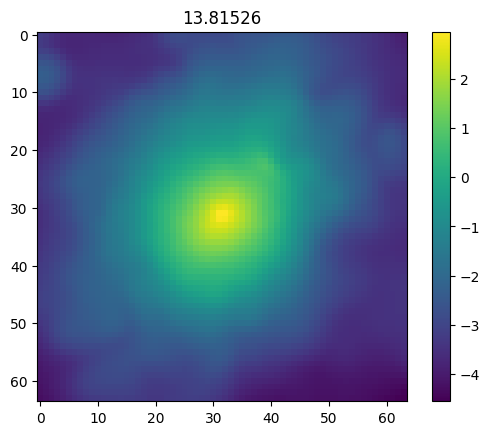

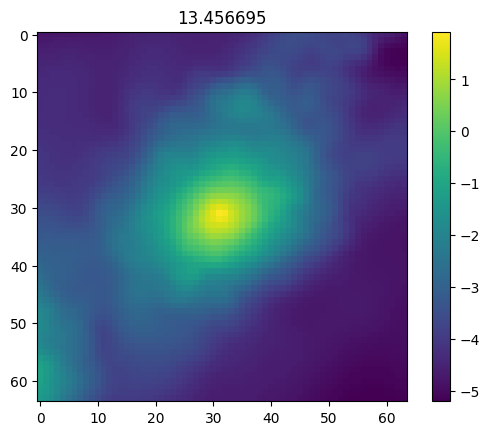

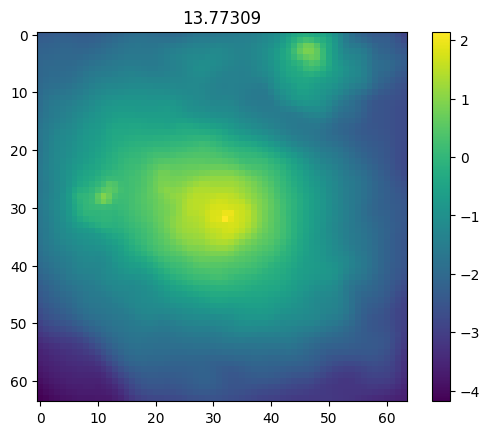

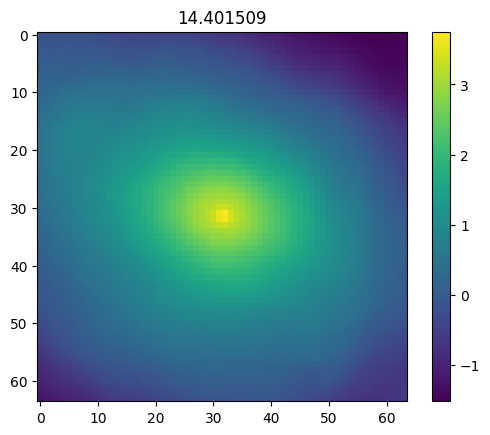

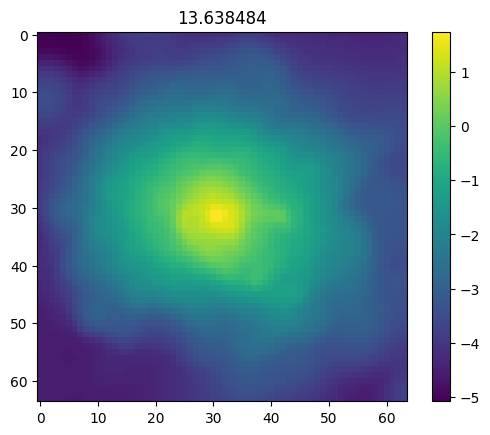

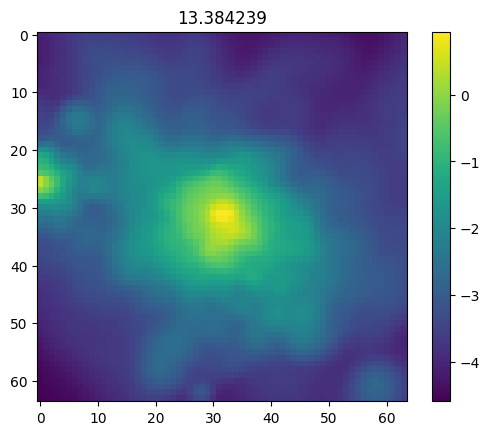

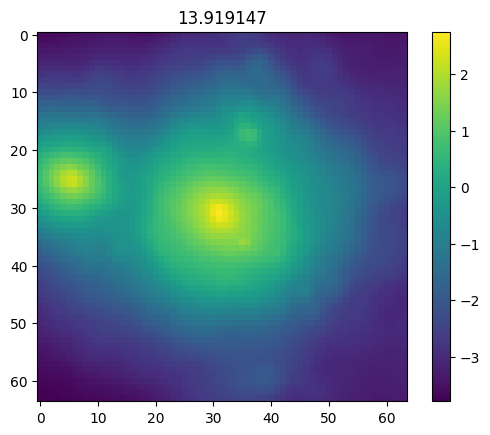

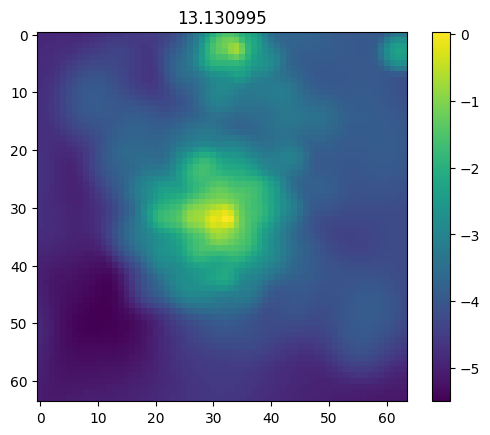

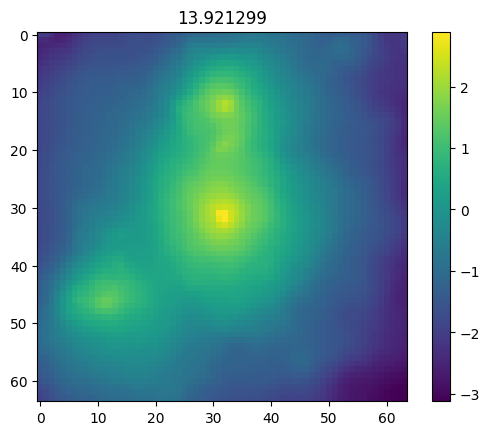

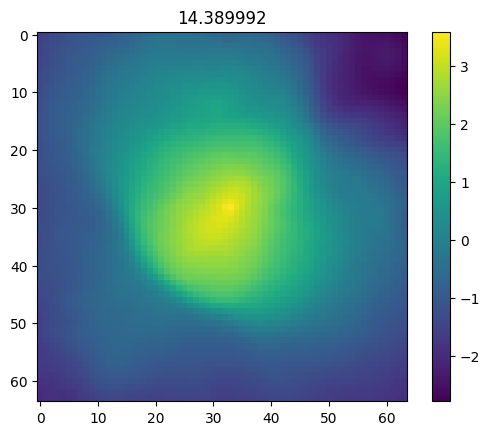

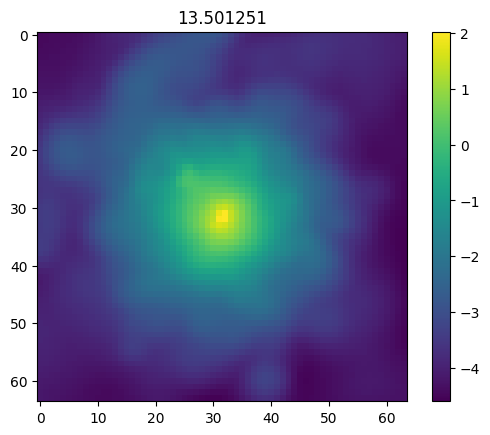

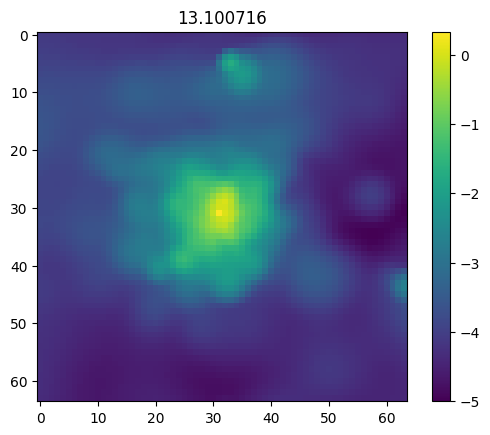

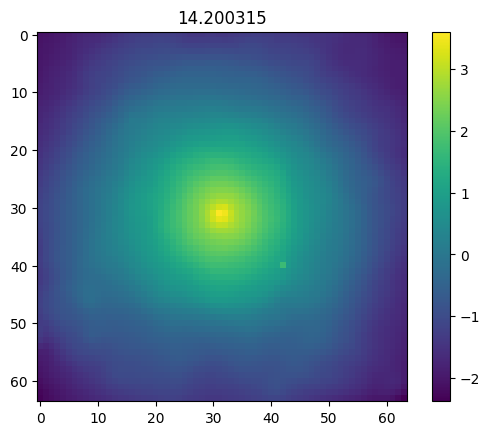

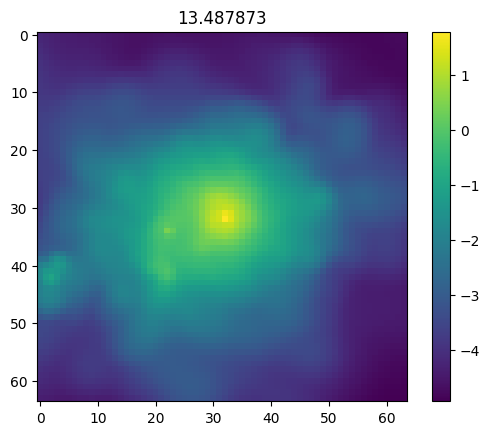

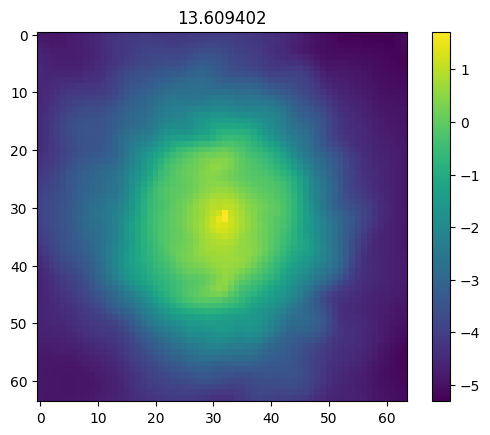

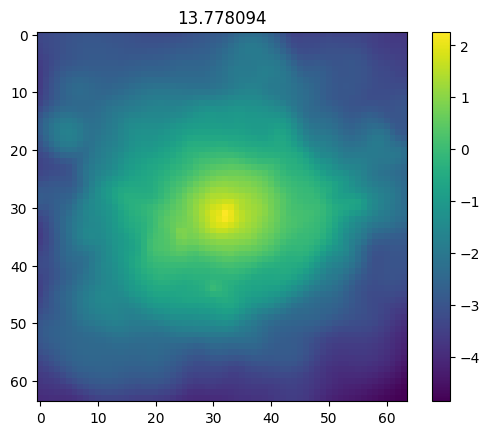

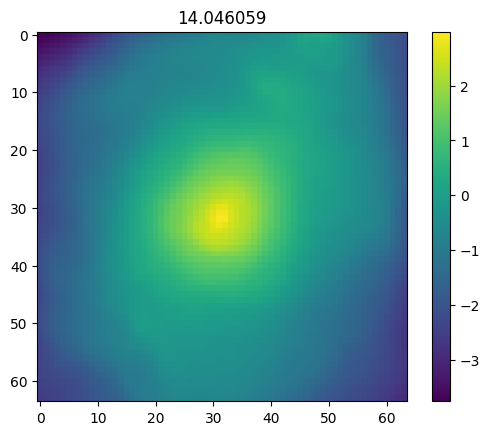

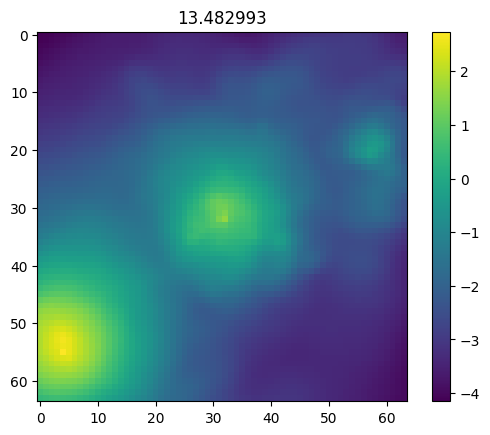

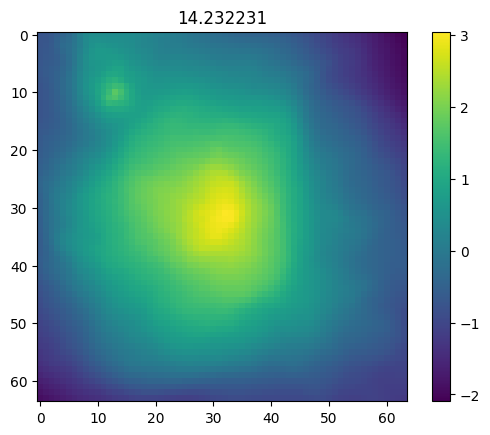

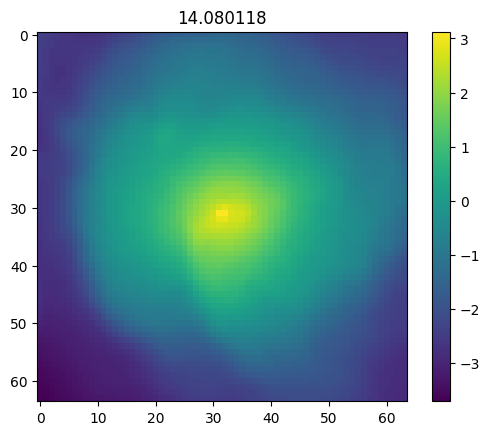

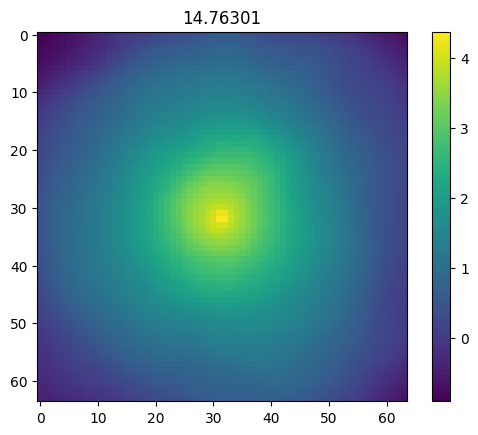

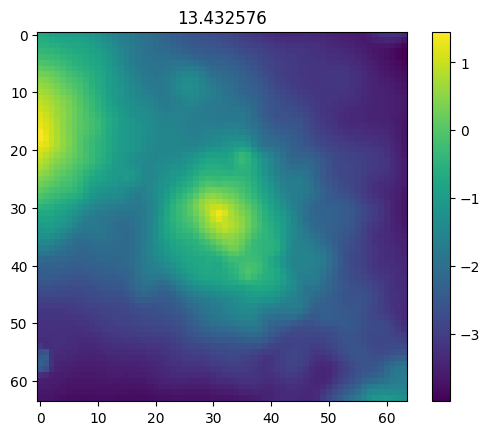

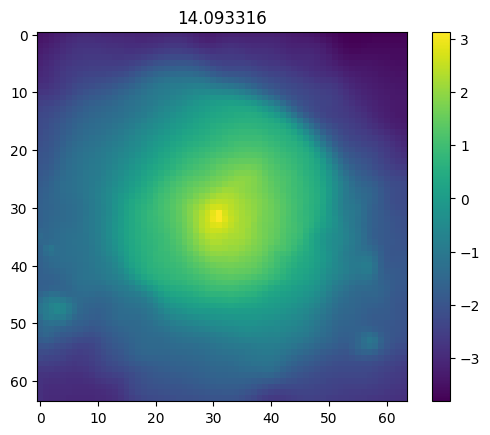

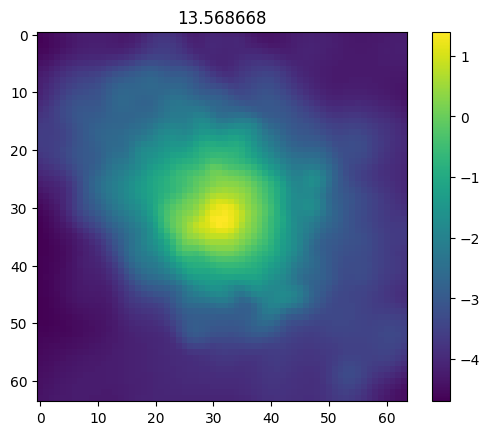

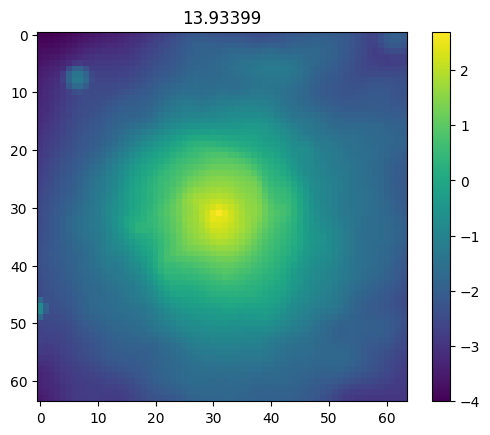

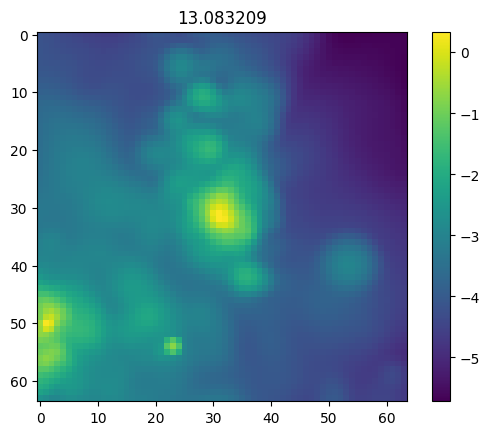

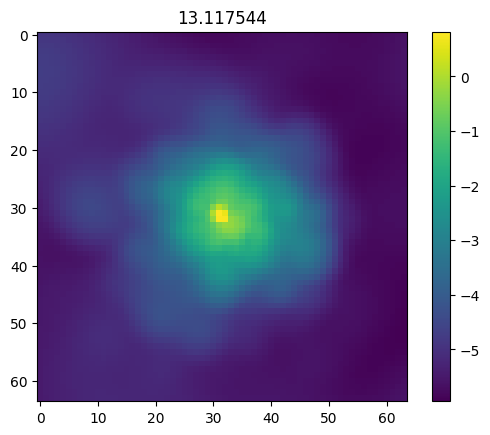

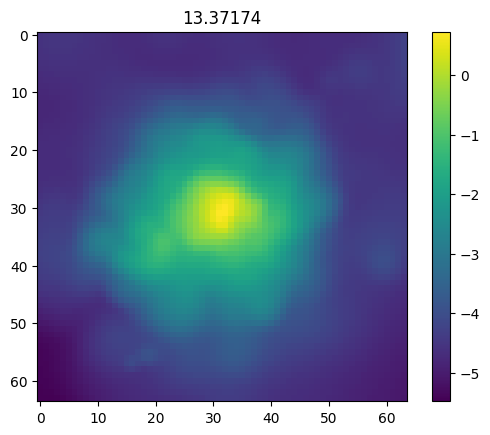

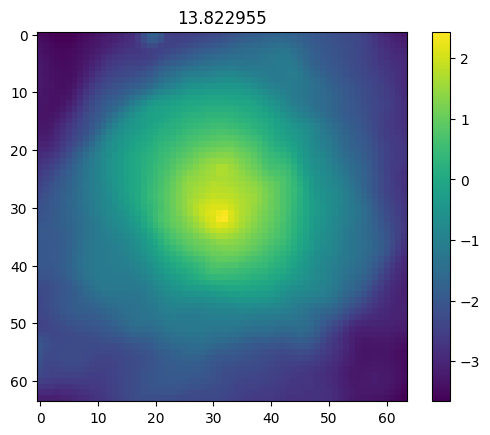

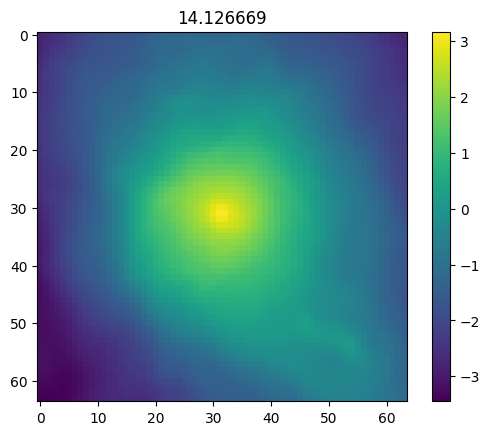

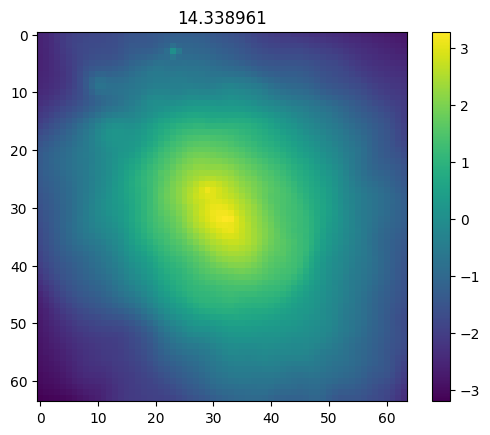

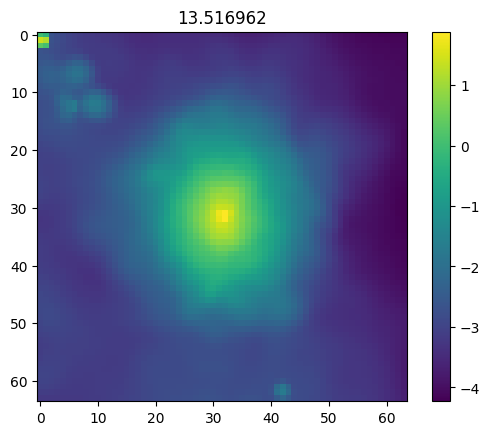

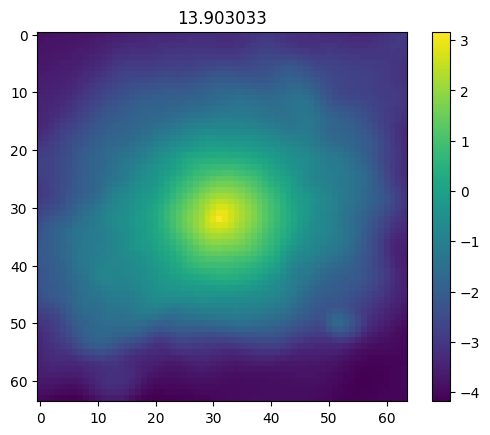

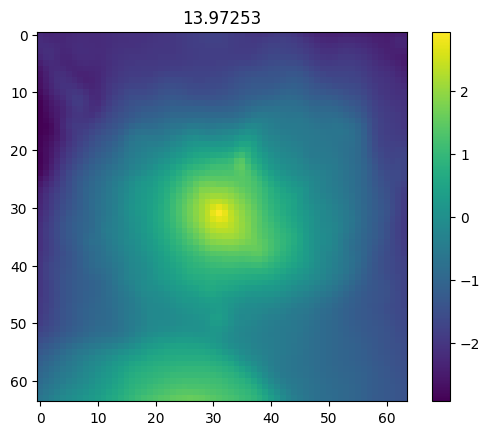

In [10]:
for i in range(0, 50):
    plt.imshow(np.log10(data.images[i, 1]))
    plt.colorbar()
    plt.title(np.log10(data.masses[i]))
    plt.show()

# Test: generate single image

In [3]:
p["obs_depth"] = 2
data = Data(p)
red, blue = data.make_obs(100, rotate=False)

/home/tol/.local/lib/python3.11/site-packages/swiftsimio/objects.py:261: RuntimeWarning: Mixing ufunc arguments with and without cosmo_factors, continuing assuming provided cosmo_factor (a**0.0 at a=0.8695652173913047) for all arguments.
  warnings.warn(


load particles 1.2599656581878662
interpolate 10.543147563934326


/home/tol/.local/lib/python3.11/site-packages/swiftsimio/objects.py:261: RuntimeWarning: Mixing ufunc arguments with and without cosmo_factors, continuing assuming provided cosmo_factor (a**1.0 at a=0.8695652173913047) for all arguments.
  warnings.warn(


project red 5.079024076461792
project blue 0.025603055953979492


/home/tol/.local/lib/python3.11/site-packages/swiftsimio/objects.py:261: RuntimeWarning: Mixing ufunc arguments with and without cosmo_factors, continuing assuming provided cosmo_factor (a**1.0 at a=0.8695652173913047) for all arguments.
  warnings.warn(


In [4]:
flux_ratio, fov = get_flux_ratio(p)
flux_ratio = flux_ratio * (1/unyt.m**2)
red = red * flux_ratio * p["obs_time"] * unyt.s
blue = blue * flux_ratio * p["obs_time"] * unyt.s

Text(0.5, 1.0, '100 Mpc deep')

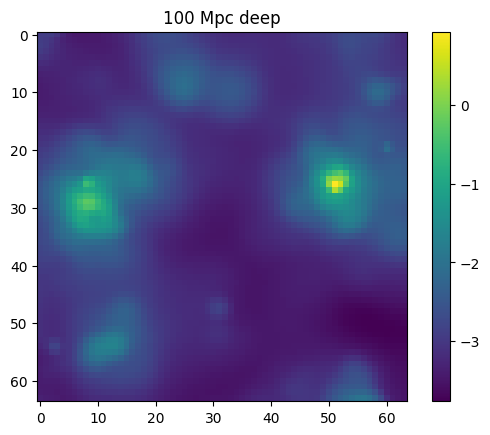

In [20]:
plt.imshow(np.log10(red))
plt.colorbar()
plt.title(str(p["obs_depth"]*2) + " Mpc deep")

In [15]:
red_sums = []
blue_sums = []

depths = [1, 2, 5, 10, 20, 30, 40, 50]
for depth in depths:
    temp_red = []
    temp_blue = []
    for i in np.arange(0, 10):
        p["obs_depth"] = depth
        data = Data(p)
        red, blue = data.make_obs(i, rotate=False)
        flux_ratio, fov = get_flux_ratio(p)
        flux_ratio = flux_ratio * (1/unyt.m**2)
        red = red * flux_ratio * p["obs_time"] * unyt.s
        blue = blue * flux_ratio * p["obs_time"] * unyt.s
        temp_red.append(np.sum(red))
        temp_blue.append(np.sum(blue))
    red_sums.append(np.mean(temp_red))
    blue_sums.append(np.mean(temp_blue))
    print(depth)

/home/tol/.local/lib/python3.11/site-packages/swiftsimio/objects.py:261: RuntimeWarning: Mixing ufunc arguments with and without cosmo_factors, continuing assuming provided cosmo_factor (a**0.0 at a=0.8695652173913047) for all arguments.
  warnings.warn(
/home/tol/.local/lib/python3.11/site-packages/swiftsimio/objects.py:261: RuntimeWarning: Mixing ufunc arguments with and without cosmo_factors, continuing assuming provided cosmo_factor (a**1.0 at a=0.8695652173913047) for all arguments.
  warnings.warn(
/home/tol/.local/lib/python3.11/site-packages/swiftsimio/objects.py:261: RuntimeWarning: Mixing ufunc arguments with and without cosmo_factors, continuing assuming provided cosmo_factor (a**1.0 at a=0.8695652173913047) for all arguments.
  warnings.warn(
/home/tol/.local/lib/python3.11/site-packages/swiftsimio/objects.py:261: RuntimeWarning: Mixing ufunc arguments with and without cosmo_factors, continuing assuming provided cosmo_factor (a**0.0 at a=0.8695652173913047) for all argument

1
2
5
10
20
30
40
50


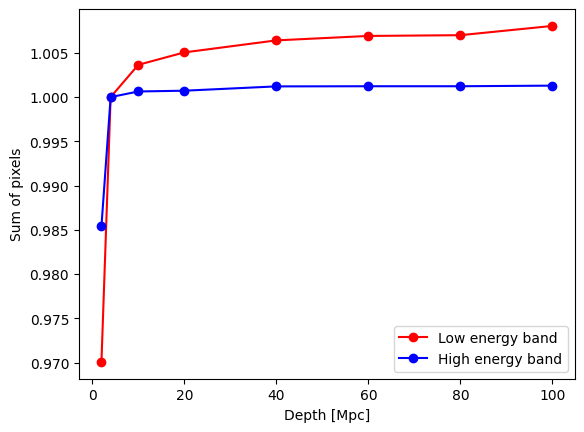

In [16]:
plt.plot(2*np.array(depths), np.array(red_sums)/red_sums[1], marker="o", color="red", label="Low energy band")
plt.plot(2*np.array(depths), np.array(blue_sums)/blue_sums[1], marker="o", color="blue", label="High energy band")
plt.xlabel("Depth [Mpc]")
plt.ylabel("Sum of pixels")
plt.legend()
plt.savefig("test_depths", dpi=300)
plt.show()

In [2]:
sw_path = f"{p_to_path(p)}/{p['snapshot_folder']}/flamingo_00{int(77-20*p['redshift'])}/flamingo_00{int(77-20*p['redshift'])}.hdf5"
mask = sw.mask(sw_path)
a = 1/(1+p["redshift"])
soap_file = h5py.File(f"{p_to_path(p)}/SOAP/halo_properties_00{int(77-20*p['redshift'])}.hdf5", "r")

In [8]:
print(np.sum(soap_file["SO/500_crit/DarkMatterMass"][:] > 10**12))

963131


In [9]:
print(np.sum(soap_file["SO/500_crit/DarkMatterMass"][:] > 10**12) * (4*unyt.Mpc * 4*unyt.Mpc * 100*unyt.Mpc)  / (1 * unyt.Gpc**3))

1.5410096000000004 dimensionless


In [13]:
print(f"{p_to_path(p)}/SOAP/halo_properties_00{int(77-20*p['redshift'])}.hdf5")

/net/hypernova/data2/FLAMINGO/L1000N1800/HYDRO_FIDUCIAL/SOAP/halo_properties_0074.hdf5


In [40]:
nr_particles = []
depths = np.logspace(0, 2, 10)
indices = np.logical_and(soap_file[f"SO/500_crit/DarkMatterMass"][:] > 10**13.4, soap_file[f"SO/500_crit/DarkMatterMass"][:] < 10**13.6)
indices = np.arange(len(indices))[indices]
np.random.shuffle(indices)

In [42]:
for i in range(len(depths)):
    amounts = []
    for halo_index in indices[:100]:
        position = soap_file[f"SO/500_crit/CentreOfMass"][halo_index] * unyt.Mpc / a
        radius = p['obs_radius'] * unyt.Mpc #use a fixed volume
        depth = depths[i] * unyt.Mpc #use a fixed depth
        ### load all particles in a square box with sides of length 2*radius
        load_box = [[position[0] - radius, position[0] + radius], 
                    [position[1] - radius, position[1] + radius], 
                    [position[2] - depth, position[2] + depth]]
        mask.constrain_spatial(load_box)
        halo_data = sw.load(sw_path, mask=mask)
        amounts.append(np.sum(halo_data.gas.xray_luminosities.erosita_low != 0))
    nr_particles.append(np.mean(amounts))
    # current_time = halo_data.metadata.cosmology.lookback_time(p["redshift"])

    ### filter out particles with AGN feedback more recent than 15 Myr
    # max_a_allowed = float(1/(1+z_at_value(halo_data.metadata.cosmology.lookback_time, current_time + 15*u.Myr)))
    # halo_mask = halo_data.gas.last_agnfeedback_scale_factors < max_a_allowed
    

Text(0, 0.5, 'Nr of particles')

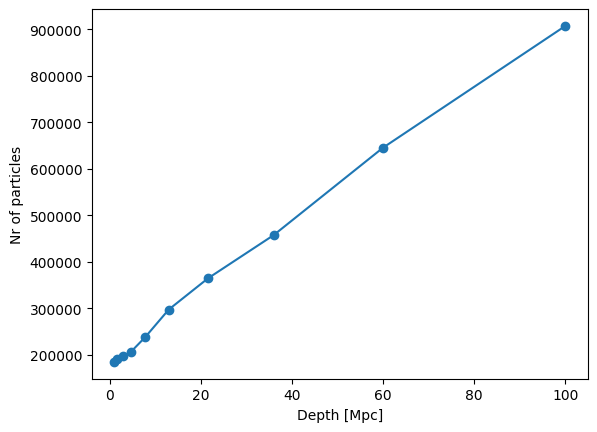

In [59]:
plt.plot(depths, nr_particles, marker="o")
# plt.plot(np.linspace(1, 100, 1000), np.linspace(10**5, 10**6, 1000))
# plt.xscale("log")
# plt.yscale("log")
plt.xlabel("Depth [Mpc]")
plt.ylabel("Nr of particles")
# plt.xlim(0, 10)
# plt.ylim(180000, 300000)